In [1]:
# importing necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import RobustScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score, 
    roc_curve, auc, precision_recall_curve, make_scorer,
    average_precision_score
)
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from numpy import mean, std

In [2]:
random_seed = 42

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# reading original dataset
df = pd.read_csv("Fbref_2023_2.csv", encoding='latin1')
df.columns = df.columns.str.strip()

In [5]:
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
for column, count in columns_with_missing_values.items():
    print(f'{column}: {count} missing values')

Columns with missing values and their counts:
Market Value Euro: 7 missing values


In [6]:
df['Market Value Euro'] = df['Market Value Euro'].str.replace(',', '')
df['Market Value Euro'] = pd.to_numeric(df['Market Value Euro'], errors='coerce').fillna(0).astype(int)

In [7]:
market_value_median = df[df['Market Value Euro'] > 0]['Market Value Euro'].median()
df['Market Value Euro'] = df['Market Value Euro'].replace(0, market_value_median)

In [8]:
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
for column, count in columns_with_missing_values.items():
    print(f'{column}: {count} missing values')

Columns with missing values and their counts:


In [9]:
print(f'Post-Cleaning Missing Values:\n{df.isnull().sum()}')

Post-Cleaning Missing Values:
Rk                   0
Edited Name          0
Original Name        0
Matching Name        0
Market Value Euro    0
Nation               0
Pos                  0
Squad                0
Comp                 0
Born                 0
MP                   0
90s                  0
Goals                0
Goals Per Match      0
Shots                0
SoT                  0
G/Sh                 0
G/SoT                0
ShoDist              0
ShoFK                0
ShoPK                0
PKatt                0
PasTotCmp            0
PasTotAtt            0
PasTotDist           0
PasTotPrgDist        0
PasShoCmp            0
PasShoAtt            0
PasMedCmp            0
PasMedAtt            0
PasLonCmp            0
PasLonAtt            0
Assists              0
PasAss               0
Pas3rd               0
PPA                  0
CrsPA                0
PasProg              0
PasLive              0
PasDead              0
PasFK                0
TB                   0
Sw  

In [10]:
df.head()

,Rk,Edited Name,Original Name,Matching Name,Market Value Euro,Nation,Pos,Squad,Comp,Born,MP,90s,Goals,Goals Per Match,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
0,1,Brenden Aaronson,Brenden Aaronson,Brenden Aaronson,25000000,USA,MF,Leeds United,Premier League,2000,20,17.7,1,0.05,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19
1,2,Yunis Abdelhamid,Yunis Abdelhamid,Yunis Abdelhamid,700000,MAR,DF,Reims,Ligue 1,1987,22,22.0,0,-,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23
2,3,Himad Abdelli,Himad Abdelli,Himad Abdelli,2500000,FRA,MF,Angers,Ligue 1,1999,14,8.6,0,-,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05
3,4,Salis Abdul Samed,Salis Abdul Samed,Salis Abdul Samed,13000000,GHA,MF,Lens,Ligue 1,2000,20,20.0,1,0.05,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50
4,5,Laurent Abergel,Laurent Abergel,Laurent Abergel,3000000,FRA,MF,Lorient,Ligue 1,1993,15,12.9,0,-,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39


In [11]:
df.describe()

,Rk,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
count,2442.000000,2.442000e+03,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000
mean,1324.375102,1.118568e+07,1996.330467,11.869369,8.264087,1.104423,1.330631,0.443612,0.068911,0.179005,15.185053,0.038800,0.008403,0.011462,33.976331,43.307928,571.371335,179.448014,16.096941,18.64459,13.756241,16.506405,2.960885,5.242219,0.088530,0.930528,2.658812,0.796441,0.214046,3.563423,39.518857,3.612158,0.901552,0.117318,0.331241,1.778943,1.966839,0.445012,0.188984,0.170749,0.003391,33.976331,0.176585,0.972899,2.198485,1.586884,0.178567,0.119521,0.160479,0.11464,0.038436,0.222416,0.152027,0.011052,0.015049,0.027707,0.013673,0.002912,1.816425,1.05645,0.867617,0.693640,0.255213,0.797666,1.533747,0.736003,1.152228,0.292789,0.859562,0.871716,1.643837,0.019521,54.790377,2.917985,14.342695,25.826912,15.218153,2.314869,54.778747,1.918600,0.765340,0.910852,32.288202,174.633018,83.667793,1.786650,1.355287,0.466048,1.774869,1.114959,35.528288,4.227203,0.254083,0.017776,0.007322,1.385459,1.203628,0.220315,1.778943,1.05645,0.010008,0.015262,0.003108,5.189902,1.374541,1.593821
std,778.250236,1.633751e+07,4.351341,6.768282,6.364620,2.074244,1.428985,0.779610,0.122111,0.267803,8.092930,0.207546,0.040666,0.051811,17.410455,18.886052,330.940994,121.803843,8.303252,8.70362,9.385421,9.891819,2.642681,3.859972,0.282853,1.095796,2.188480,1.092908,0.539694,2.517976,17.751095,3.787436,1.095920,0.398575,0.586980,2.362002,3.405369,1.117561,0.669826,0.525090,0.030025,17.410455,0.416665,1.088265,1.895857,1.428765,0.499852,0.464115,0.477930,0.27421,0.164184,0.475926,0.351678,0.055001,0.142740,0.260786,0.057264,0.024733,1.737980,1.25410,1.181219,0.929353,0.589007,1.018922,1.524399,0.981666,1.195067,0.495496,1.114037,0.878527,1.740125,0.065221,19.295595,3.163739,11.142585,12.474453,10.248563,2.515421,19.300294,2.264234,1.199748,1.280282,14.148413,96.267585,57.622085,1.942555,1.543943,0.890674,1.859116,1.535594,15.111736,4.126963,0.599642,0.235879,0.114240,1.431151,1.235570,0.573939,2.362002,1.25410,0.045635,0.078134,0.021258,2.812007,1.570325,1.860780

In [12]:
# Encode categorical features
le = LabelEncoder()
df['Pos_Cat'] = le.fit_transform(df['Pos'])
df['Nation_Cat'] = le.fit_transform(df['Nation'])
df['Squad_Cat'] = le.fit_transform(df['Squad'])
df['Comp_Cat'] = le.fit_transform(df['Comp'])

In [13]:
df.head()

,Rk,Edited Name,Original Name,Matching Name,Market Value Euro,Nation,Pos,Squad,Comp,Born,MP,90s,Goals,Goals Per Match,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,1,Brenden Aaronson,Brenden Aaronson,Brenden Aaronson,25000000,USA,MF,Leeds United,Premier League,2000,20,17.7,1,0.05,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,2,98,44,3
1,2,Yunis Abdelhamid,Yunis Abdelhamid,Yunis Abdelhamid,700000,MAR,DF,Reims,Ligue 1,1987,22,22.0,0,-,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,0,64,73,2
2,3,Himad Abdelli,Himad Abdelli,Himad Abdelli,2500000,FRA,MF,Angers,Ligue 1,1999,14,8.6,0,-,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,2,36,2,2
3,4,Salis Abdul Samed,Salis Abdul Samed,Salis Abdul Samed,13000000,GHA,MF,Lens,Ligue 1,2000,20,20.0,1,0.05,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,2,41,46,2
4,5,Laurent Abergel,Laurent Abergel,Laurent Abergel,3000000,FRA,MF,Lorient,Ligue 1,1993,15,12.9,0,-,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,2,36,50,2


In [14]:
numeric_df = df.select_dtypes(include=[np.number])

In [15]:
numeric_df.head()

,Rk,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,1,25000000,2000,20,17.7,1,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,2,98,44,3
1,2,700000,1987,22,22.0,0,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,0,64,73,2
2,3,2500000,1999,14,8.6,0,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,2,36,2,2
3,4,13000000,2000,20,20.0,1,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,2,41,46,2
4,5,3000000,1993,15,12.9,0,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,2,36,50,2


In [16]:
def find_outliers(data):
    outliers_dict = {}
    for column in data.columns:
        Q1 = np.percentile(data[column], 25)
        Q3 = np.percentile(data[column], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outliers_dict[column] = len(outliers)
    return outliers_dict

outliers = find_outliers(numeric_df)

sorted_outliers = dict(sorted(outliers.items(), key=lambda item: item[1]))

for col, num_outliers in sorted_outliers.items():
    print(f'{col}: {num_outliers} outliers')

Rk: 0 outliers
MP: 0 outliers
90s: 0 outliers
Pos_Cat: 0 outliers
Squad_Cat: 0 outliers
Comp_Cat: 0 outliers
Born: 1 outliers
ShoDist: 12 outliers
PasTotPrgDist: 23 outliers
PasLonAtt: 27 outliers
PasTotAtt: 29 outliers
TouDef3rd: 30 outliers
PasTotDist: 31 outliers
PasTotCmp: 35 outliers
PasCmp: 35 outliers
PasMedAtt: 37 outliers
PasLive: 45 outliers
RecProg: 47 outliers
PasMedCmp: 48 outliers
Recov: 49 outliers
ScaPassLive: 54 outliers
PasShoCmp: 55 outliers
PasFK: 55 outliers
TouAtt3rd: 55 outliers
SCA: 56 outliers
PasShoAtt: 58 outliers
CkStr: 58 outliers
Int: 58 outliers
PasAss: 59 outliers
TouMid3rd: 60 outliers
PasLonCmp: 64 outliers
CarTotDist: 66 outliers
Carries: 67 outliers
Clr: 69 outliers
GcaDef: 70 outliers
CarMis: 70 outliers
TklDri: 72 outliers
Shots: 76 outliers
Touches: 78 outliers
TouLive: 78 outliers
CarProg: 78 outliers
Fld: 78 outliers
PPA: 79 outliers
PasProg: 79 outliers
TouAttPen: 81 outliers
TklDef3rd: 82 outliers
Car3rd: 82 outliers
OG: 82 outliers
TklDriAtt:

In [17]:
def find_outliers(data):
    outliers_dict = {}
    for column in data.columns:
        Q1 = np.percentile(data[column], 25)
        Q3 = np.percentile(data[column], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outliers_dict[column] = len(outliers)
    return outliers_dict

outliers = find_outliers(numeric_df)

filtered_outliers = {col: num_outliers for col, num_outliers in outliers.items() if num_outliers > 0}
sorted_outliers = dict(sorted(filtered_outliers.items(), key=lambda item: item[1]))

for col, num_outliers in sorted_outliers.items():
    print(f'{col}: {num_outliers} outliers')

Born: 1 outliers
ShoDist: 12 outliers
PasTotPrgDist: 23 outliers
PasLonAtt: 27 outliers
PasTotAtt: 29 outliers
TouDef3rd: 30 outliers
PasTotDist: 31 outliers
PasTotCmp: 35 outliers
PasCmp: 35 outliers
PasMedAtt: 37 outliers
PasLive: 45 outliers
RecProg: 47 outliers
PasMedCmp: 48 outliers
Recov: 49 outliers
ScaPassLive: 54 outliers
PasShoCmp: 55 outliers
PasFK: 55 outliers
TouAtt3rd: 55 outliers
SCA: 56 outliers
PasShoAtt: 58 outliers
CkStr: 58 outliers
Int: 58 outliers
PasAss: 59 outliers
TouMid3rd: 60 outliers
PasLonCmp: 64 outliers
CarTotDist: 66 outliers
Carries: 67 outliers
Clr: 69 outliers
GcaDef: 70 outliers
CarMis: 70 outliers
TklDri: 72 outliers
Shots: 76 outliers
Touches: 78 outliers
TouLive: 78 outliers
CarProg: 78 outliers
Fld: 78 outliers
PPA: 79 outliers
PasProg: 79 outliers
TouAttPen: 81 outliers
TklDef3rd: 82 outliers
Car3rd: 82 outliers
OG: 82 outliers
TklDriAtt: 85 outliers
CarPrgDist: 86 outliers
CarDis: 86 outliers
SoT: 87 outliers
Tkl: 87 outliers
2CrdY: 88 outliers

In [18]:
features_to_scale = numeric_df.drop(columns=['Pos_Cat', 'Nation_Cat', 'Squad_Cat', 'Comp_Cat'])

In [55]:
# Scale features using RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features_to_scale)

In [56]:
joblib.dump(scaler, 'robust_scaler.pkl')

['robust_scaler.pkl']

In [20]:
scaled_numeric_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

In [21]:
# Add categorical features back
scaled_numeric_df['Pos_Cat'] = df['Pos_Cat']
scaled_numeric_df['Nation_Cat'] = df['Nation_Cat']
scaled_numeric_df['Squad_Cat'] = df['Squad_Cat']
scaled_numeric_df['Comp_Cat'] = df['Comp_Cat']

In [22]:
if 'Rk' in scaled_numeric_df.columns:
    scaled_numeric_df = scaled_numeric_df.drop('Rk', axis=1)

In [23]:
scaled_numeric_df.head()

,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,1.666667,0.428571,0.538462,0.902655,1.0,0.360759,0.078125,0.363636,0.606061,0.325843,0.11,0.0,0.0,-0.434091,-0.492179,-0.568352,-0.458913,-0.185567,-0.16,-0.539496,-0.644929,-0.500000,-0.460076,0.916667,0.900901,-0.235417,-0.132653,0.392857,-0.041045,-0.491647,0.178984,0.258741,1.307692,-0.340426,0.657921,-0.025478,7.736842,0.68,0.62,0.06,-0.434091,-0.375000,0.021505,0.785377,0.617886,4.307692,2.090909,0.578947,1.898305,0.06,0.5625,0.500000,0.0,0.0,0.06,0.0,0.06,0.034965,-0.398922,-0.252632,0.501742,0.424242,-0.166667,0.108527,0.547945,0.8375,-0.071429,1.208333,-0.674699,-0.4175,0.06,-0.464912,-0.465504,-0.498778,-0.407871,0.515873,0.357934,-0.464912,1.086809,0.813187,1.000000,-0.238994,-0.238848,-0.327115,0.101010,-0.006944,0.426230,0.692737,1.862903,-0.213415,0.338652,-0.133333,0.0,0.0,-0.53,1.103448,0.708333,0.657921,-0.398922,0.0,0.0,0.00,-0.084291,-0.468531,0.016,2,98,44,3
1,-0.358333,-1.428571,0.692308,1.283186,0.0,-0.063291,-0.281250,0.000000,0.000000,-0.292135,0.00,0.0,0.0,0.261364,0.183525,0.471095,0.876524,-0.432990,-0.49,0.911765,0.792158,0.396875,0.420152,0.416667,-0.432432,0.247917,-0.500000,0.000000,0.436567,0.233890,0.375289,1.909091,0.000000,0.829787,-0.294652,-0.114650,0.000000,0.00,0.00,0.00,0.261364,0.583333,-0.258065,-0.384434,-0.364228,0.000000,0.000000,0.947368,0.000000,0.09,0.2500,0.363636,0.0,0.0,0.05,0.0,0.00,0.636364,0.765499,0.800000,0.641115,-0.272727,0.797619,0.271318,-0.273973,1.5125,1.500000,1.027778,1.195181,0.8975,0.05,0.201754,1.302502,1.010595,0.343470,-0.973810,-0.158672,0.201754,-0.288613,-0.142857,-0.168067,0.597484,0.687279,0.859870,-0.393939,-0.590278,-0.081967,-0.351955,-0.096774,0.048780,-0.622340,-0.200000,0.0,0.0,0.17,-0.413793,0.208333,-0.294652,0.765499,0.0,0.0,0.00,0.597701,0.818182,0.048,0,64,73,2
2,-0.208333,0.285714,0.076923,0.097345,0.0,0.056962,0.187500,0.000000,0.000000,0.348315,0.00,0.0,0.0,0.329545,0.279458,0.299932,0.128496,0.350515,0.42,0.264706,0.232046,0.600000,0.216730,0.000000,0.684685,0.681250,1.183673,1.250000,1.145522,0.463007,-0.218245,-0.167832,0.923077,0.148936,0.056509,0.343949,0.000000,0.00,0.00,0.00,0.329545,0.583333,0.354839,0.337264,0.663415,0.000000,0.000000,0.631579,0.000000,0.12,-0.3125,-0.272727,0.0,0.0,0.00,0.0,0.00,0.923077,0.560647,0.621053,1.198606,0.272727,1.166667,1.038760,0.671233,0.6125,-0.047619,0.958333,0.163855,-0.0925,0.00,0.350877,-0.304776,-0.039120,0.808587,0.190476,-0.132841,0.350877,1.136415,1.802198,0.798319,1.132075,1.294312,1.311063,0.621212,1.027778,0.540984,0.407821,0.201613,0.591463,0.388298,-0.100000,0.0,0.0,0.59,0.258621,0.000000,0.056509,0.560647,0.0,0.0,0.00,1.172414,-0.055944,-0.096,2,36,2,2
3,0.666667,0.428571,0.538462,1.106195,1.0,-0.227848,-0.125000,0.727273,1.000000,0.471910,0.00,0.0,0.0,1.215909,0.921794,0.912718,0.351068,1.494845,1.40,1.037815,0.832166,0.265625,-0.093156,0.000000,-0.225225,1.535417,-0.030612,0.357143,0.847015,1.178998,-0.162818,0.496503,0.384615,0.085106,-0.226034,-0.108280,0.000000,0.00,0.00,0.00,1.215909,1.083333,-0.462366,-0.167453,-0.045528,0.000000,0.909091,0.526316,0.000000,0.05,-0.3125,-0.272727,0.0,0.0,0.00,0.0,0.00,-0.062937,-0.086253,-0.147368,0.432056,-0.121212,0.238095,-0.023256,-0.150685,0.3500,0.500000,0.33

In [24]:
scaled_numeric_df.describe()

,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
count,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2.442000e+03,2442.000000,2442.000000,2.442000e+03,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2.442000e+03,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2.442000e+03,2442.000000,2442.000000,2.442000e+03,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000
mean,0.515473,-0.095648,-0.086972,0.067618,1.104423,0.234576,0.333768,0.626461,0.542439,-0.102803,0.038800,0.008403,0.011462,0.055742,0.021186,0.062733,7.886427e-02,0.102777,0.084459,1.181715e-01,0.056524,0.144026,0.085973,0.737749,0.162638,0.143255,0.220859,0.764450,0.087098,0.053406,0.348073,0.217869,0.902444,0.364342,0.350734,1.080789,2.342170,0.188984,0.170749,0.003391,0.055742,0.360770,0.153655,1.148513e-01,0.108542,1.373590,1.086553,0.844627,0.777218,0.038436,0.382550,0.418305,0.011052,0.015049,0.027707,0.013673,0.002912,0.158339,0.190242,0.186965,0.214133,0.349130,0.175793,0.157943,0.241100,0.165285,0.363783,0.207725,0.107678,2.644185e-01,0.019521,0.008350,2.981002e-01,0.152743,0.080638,0.017314,0.293310,0.007840,0.269943,0.346527,0.294833,0.112466,0.124928,0.142608,0.230631,0.191171,0.534505,0.231770,0.253999,0.111481,0.086384,0.346942,0.017776,0.007322,0.235459,0.192783,0.917980,0.350734,0.190242,0.010008,0.015262,0.003108,0.042108,0.254924,0.339057,0.963964,43.294840,48.814087,2.047502
std,1.361459,0.621620,0.520637,0.563241,2.074244,0.904421,1.218141,1.110096,0.811523,0.909318,0.207546,0.040666,0.051811,0.791384,0.787739,0.750263,6.987170e-01,0.856005,0.870362,7.886908e-01,0.791504,0.825838,0.733835,2.357106,0.987203,0.911867,1.115212,1.927477,0.939543,0.847308,0.874696,0.766377,3.065960,1.248894,0.953381,2.169025,5.881899,0.669826,0.525090,0.030025,0.791384,1.736102,1.170177,8.942724e-01,0.929278,3.845012,4.219228,2.515423,1.859049,0.164184,1.487268,1.598538,0.055001,0.142740,0.260786,0.057264,0.024733,1.215371,1.352129,1.243389,1.295266,1.784871,1.213003,1.181705,1.344748,1.493834,1.179753,1.547274,0.846773,8.700624e-01,0.065221,0.846298,9.594356e-01,0.726493,0.892626,0.813378,0.928199,0.846504,1.021075,1.318404,1.075867,0.889837,0.908828,0.999949,0.981089,1.072182,1.460121,1.038612,1.238383,0.921447,0.731731,1.998806,0.235879,0.114240,1.431

C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


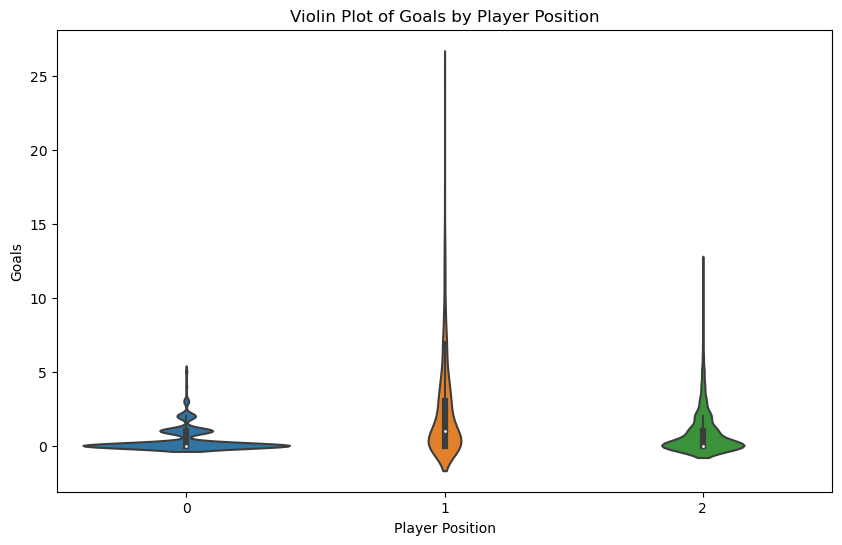

In [25]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Pos_Cat', y='Goals', data=scaled_numeric_df)
plt.title('Violin Plot of Goals by Player Position')
plt.xlabel('Player Position')
plt.ylabel('Goals')
plt.show()

C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


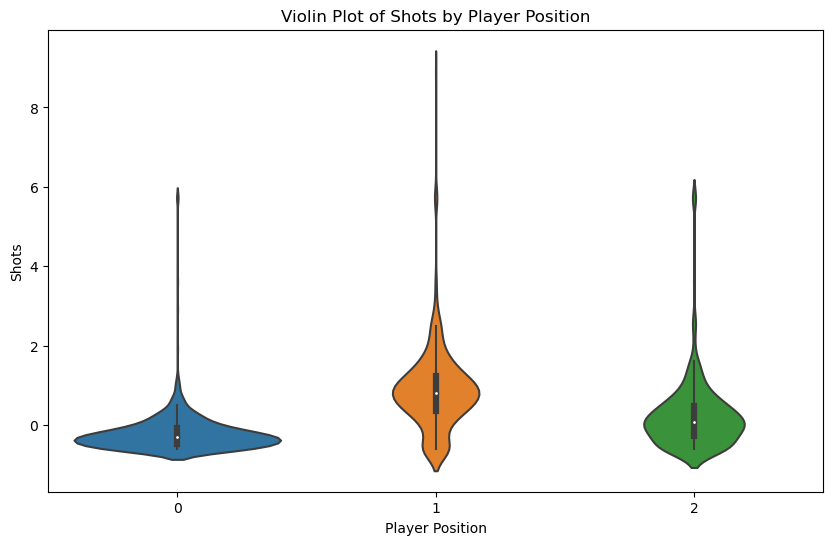

In [28]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Pos_Cat', y='Shots', data=scaled_numeric_df)
plt.title('Violin Plot of Shots by Player Position')
plt.xlabel('Player Position')
plt.ylabel('Shots')
plt.show()

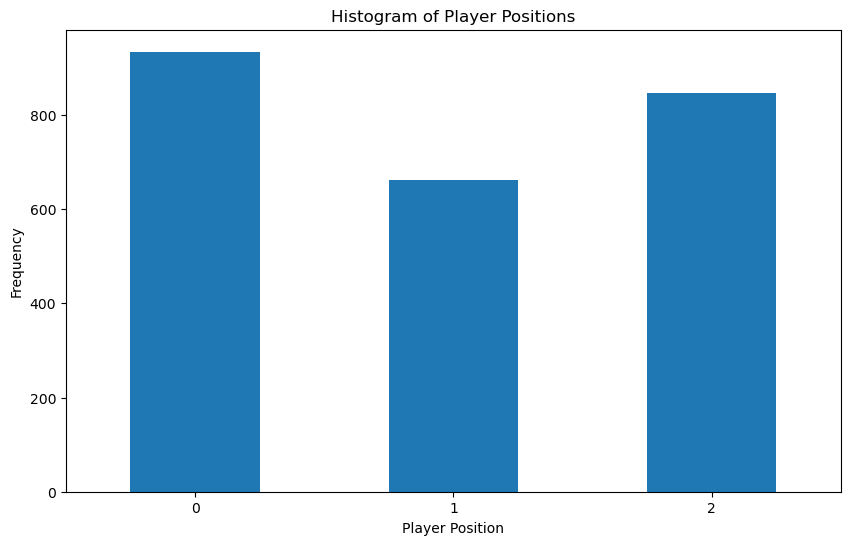

Mean number of players per position: 814.0
Standard deviation of players per position: 138.79481258317978
Range of players per position: 272


In [29]:
plt.figure(figsize=(10, 6))
position_counts = scaled_numeric_df['Pos_Cat'].value_counts().sort_index()
position_counts.plot(kind='bar')
plt.title('Histogram of Player Positions')
plt.xlabel('Player Position')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.show()


mean_position = position_counts.mean()
std_dev_position = position_counts.std()
range_position = position_counts.max() - position_counts.min()

print(f"Mean number of players per position: {mean_position}")
print(f"Standard deviation of players per position: {std_dev_position}")
print(f"Range of players per position: {range_position}")

In [30]:
unique_pos = df['Pos'].unique()
print("Unique values in 'pos':")
print(unique_pos)

Unique values in 'pos':
['MF' 'DF' 'FW']


In [31]:
pos_mapping = df[['Pos', 'Pos_Cat']].drop_duplicates().sort_values(by='Pos_Cat').reset_index(drop=True)

print("Mapping between 'pos' and 'pos_cat':")
print(pos_mapping)

Mapping between 'pos' and 'pos_cat':
  Pos  Pos_Cat
0  DF        0
1  FW        1
2  MF        2


In [32]:
df['Pos_Cat'].value_counts()

Pos_Cat
0    934
2    846
1    662
Name: count, dtype: int64

Mean number of players per league: 488.4
Standard deviation of players per league: 27.509998182479034
Range of players per league: 72


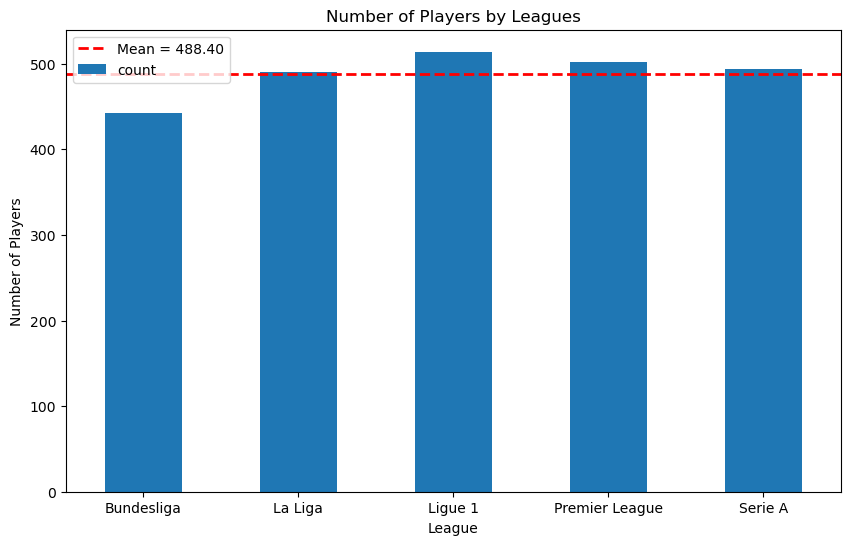

Comp
Bundesliga        442
La Liga           490
Ligue 1           514
Premier League    502
Serie A           494
Name: count, dtype: int64


In [33]:
league_counts = df['Comp'].value_counts().sort_index()

mean_count = league_counts.mean()
std_dev_count = league_counts.std()
range_count = league_counts.max() - league_counts.min()

print(f"Mean number of players per league: {mean_count}")
print(f"Standard deviation of players per league: {std_dev_count}")
print(f"Range of players per league: {range_count}")

plt.figure(figsize=(10, 6))
league_counts.plot(kind='bar')
plt.axhline(mean_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_count:.2f}')
plt.title('Number of Players by Leagues')
plt.xlabel('League')
plt.ylabel('Number of Players')
plt.xticks(rotation=0)  
plt.legend()
plt.show()

print(league_counts)

C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

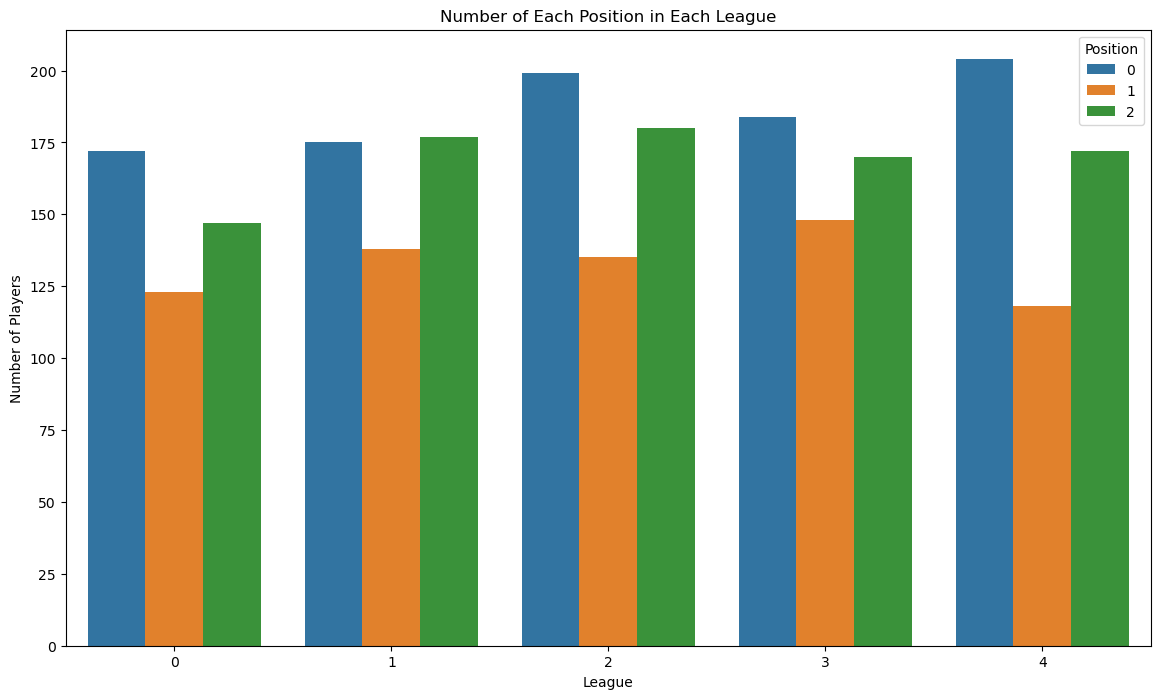

In [34]:
plt.figure(figsize=(14, 8))

sns.countplot(data=scaled_numeric_df, x='Comp_Cat', hue='Pos_Cat')

plt.title('Number of Each Position in Each League')
plt.xlabel('League')
plt.ylabel('Number of Players')
plt.xticks(rotation=0)  
plt.legend(title='Position')


plt.show()

C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


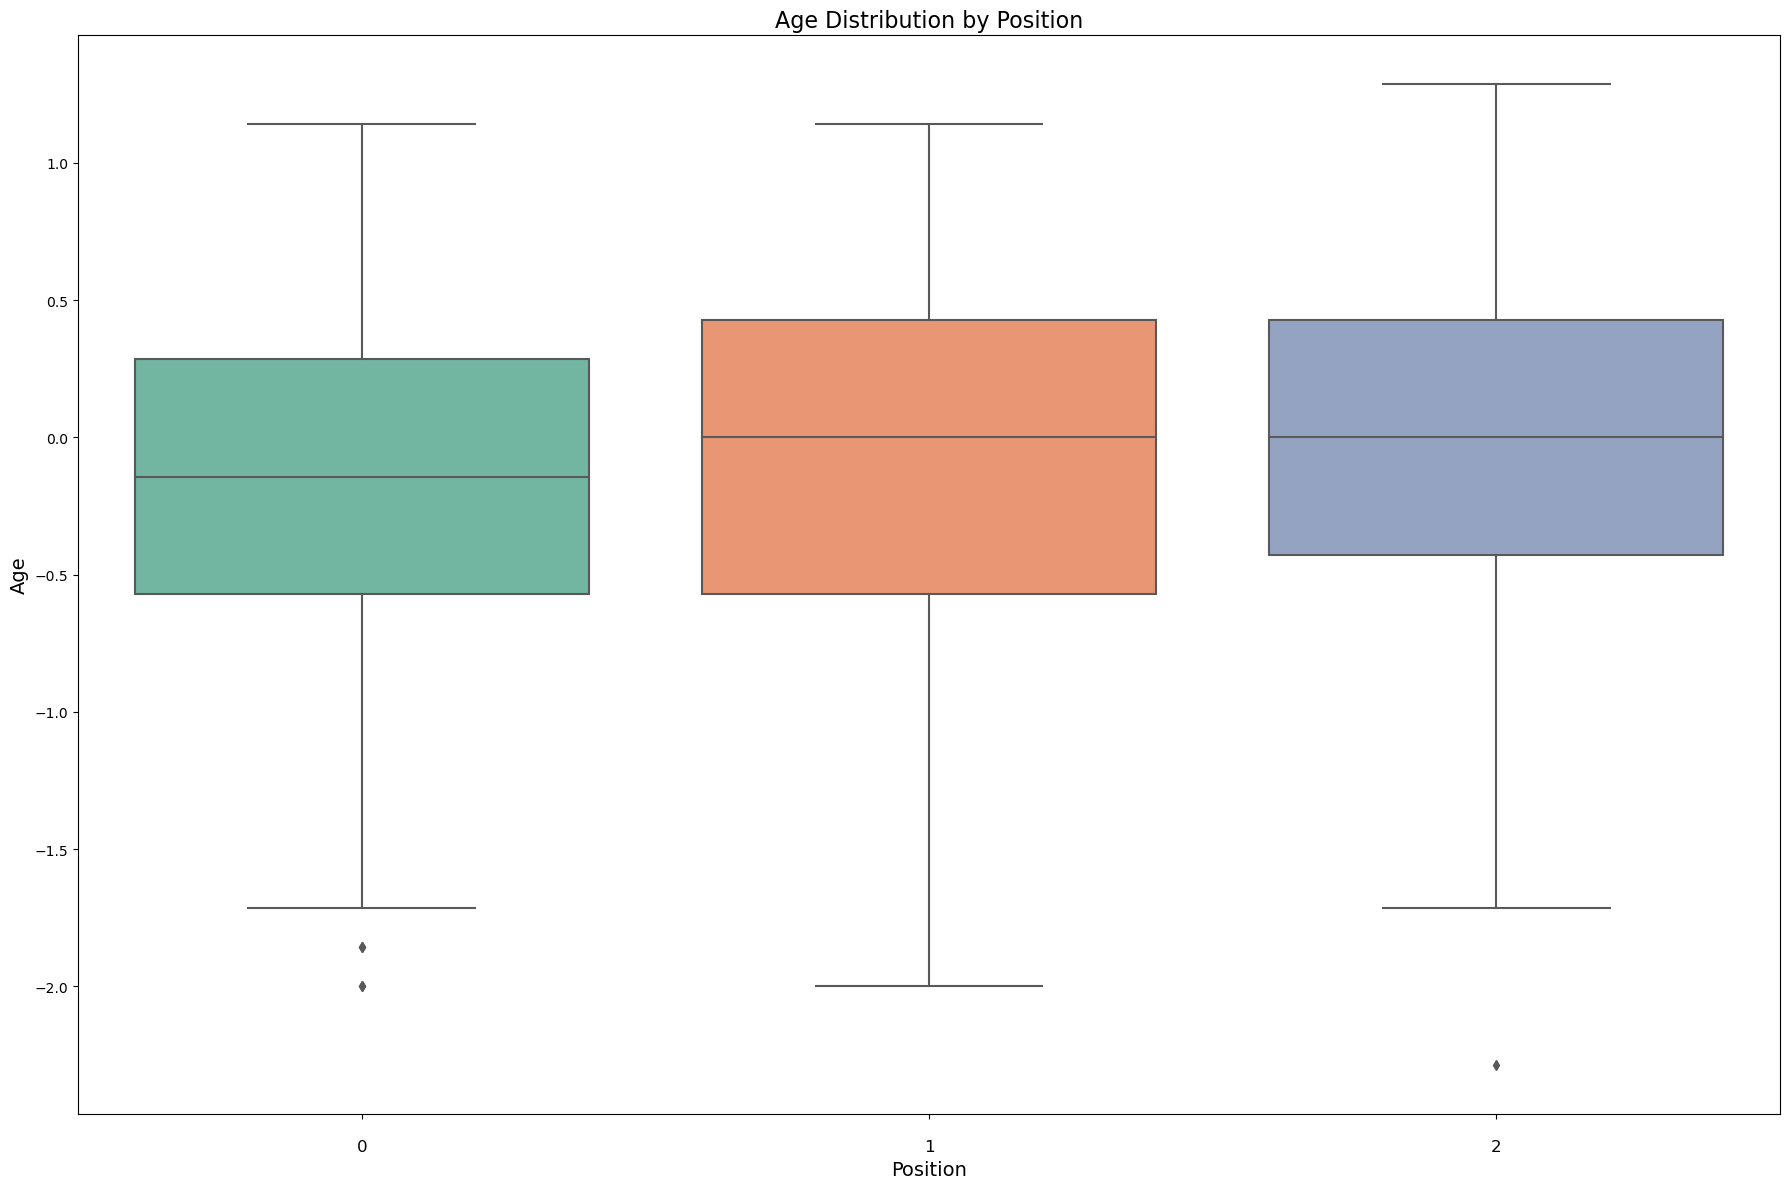

In [62]:
plt.figure(figsize=(18, 12))  


sns.boxplot(data=scaled_numeric_df, x='Pos_Cat', y='Born', palette='Set2')


plt.title('Age Distribution by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Age', fontsize=14)


plt.xticks(rotation=0, ha='center', fontsize=12)  
plt.gca().tick_params(axis='x', pad=15)  

plt.subplots_adjust(bottom=0.25)  

plt.tight_layout()

plt.show()

C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


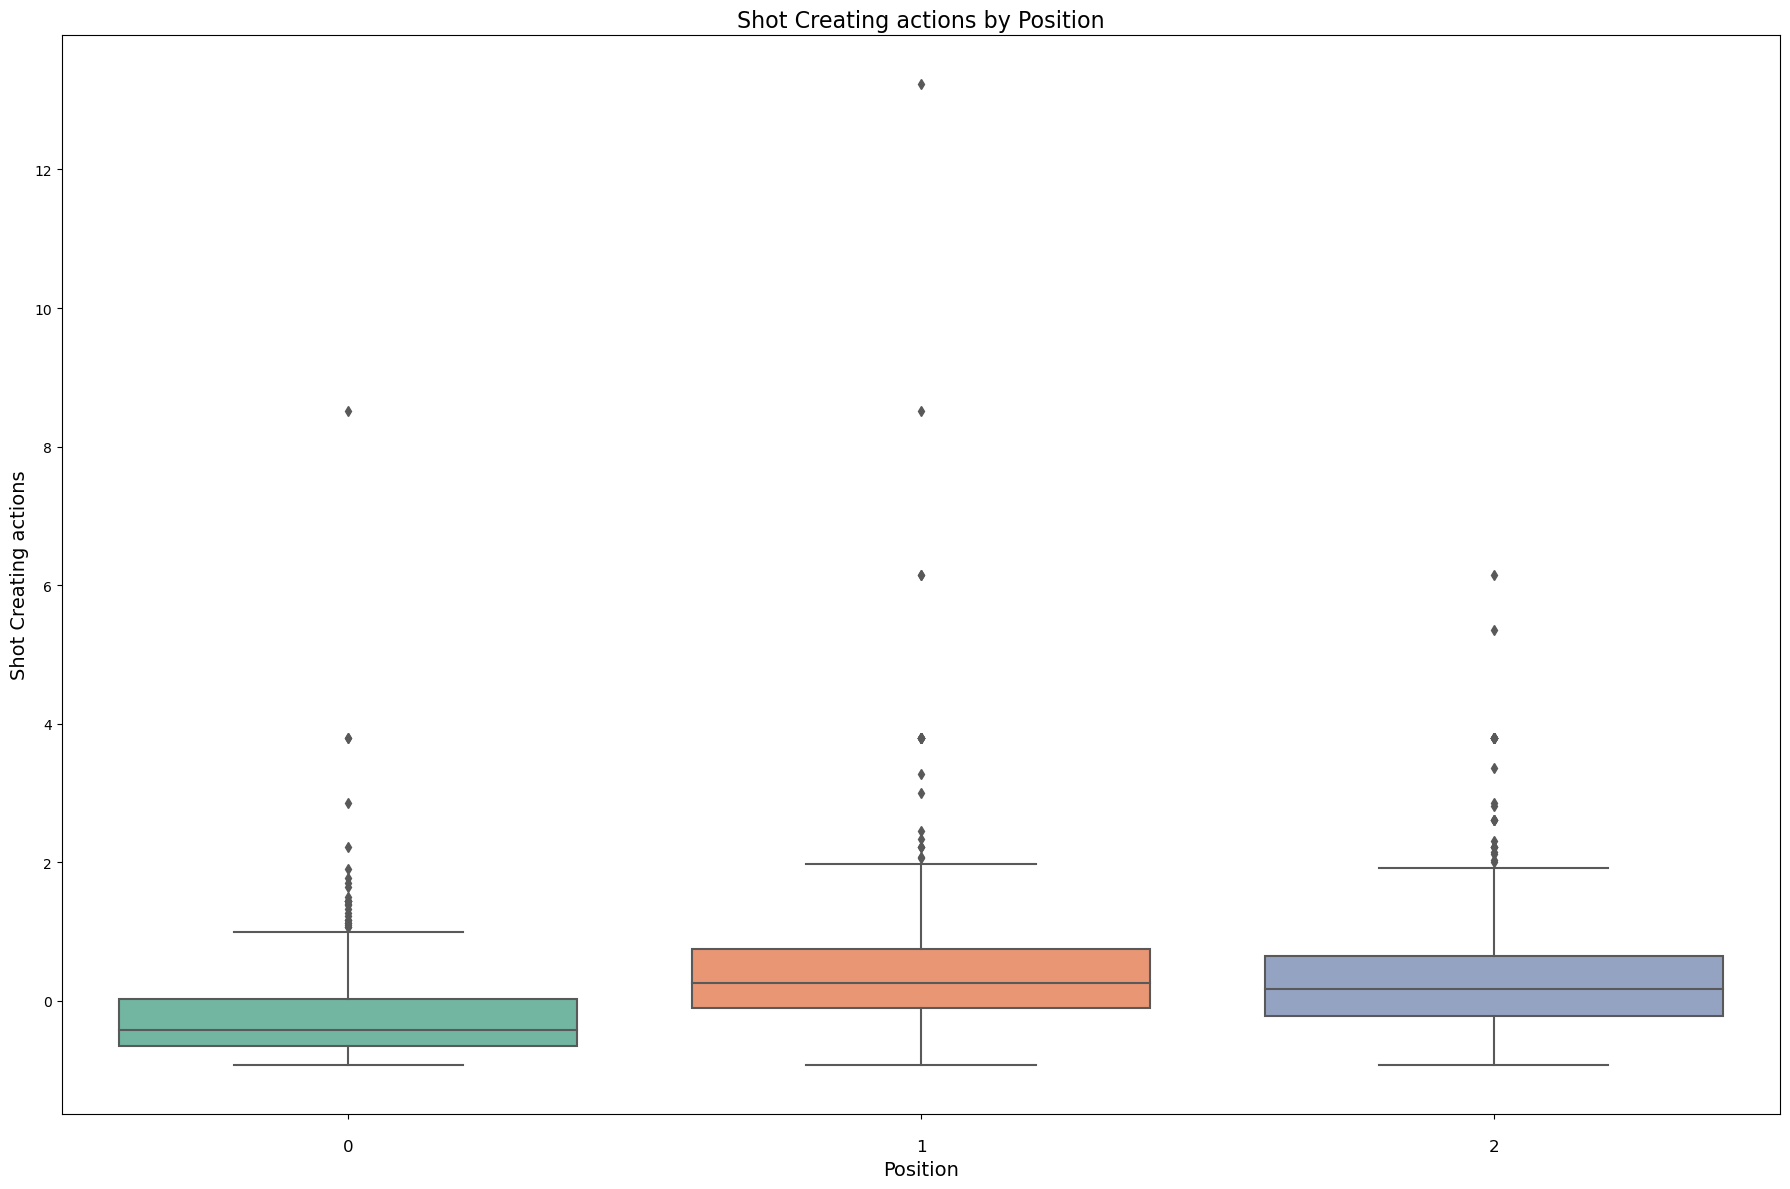

In [63]:
plt.figure(figsize=(18, 12))  


sns.boxplot(data=scaled_numeric_df, x='Pos_Cat', y='SCA', palette='Set2')


plt.title('Shot Creating actions by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Shot Creating actions', fontsize=14)


plt.xticks(rotation=0, ha='center', fontsize=12)  
plt.gca().tick_params(axis='x', pad=15)  

plt.subplots_adjust(bottom=0.25)  

plt.tight_layout()

plt.show()

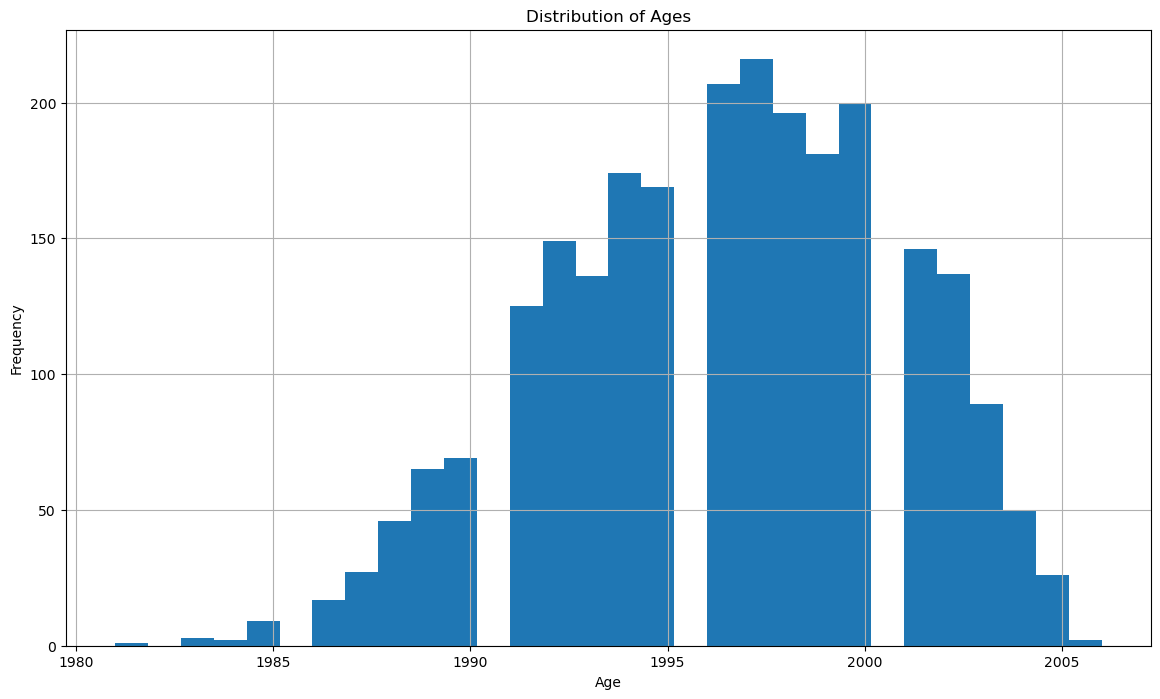

In [36]:
plt.figure(figsize=(14, 8))
df['Born'].hist(bins=30)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\firda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

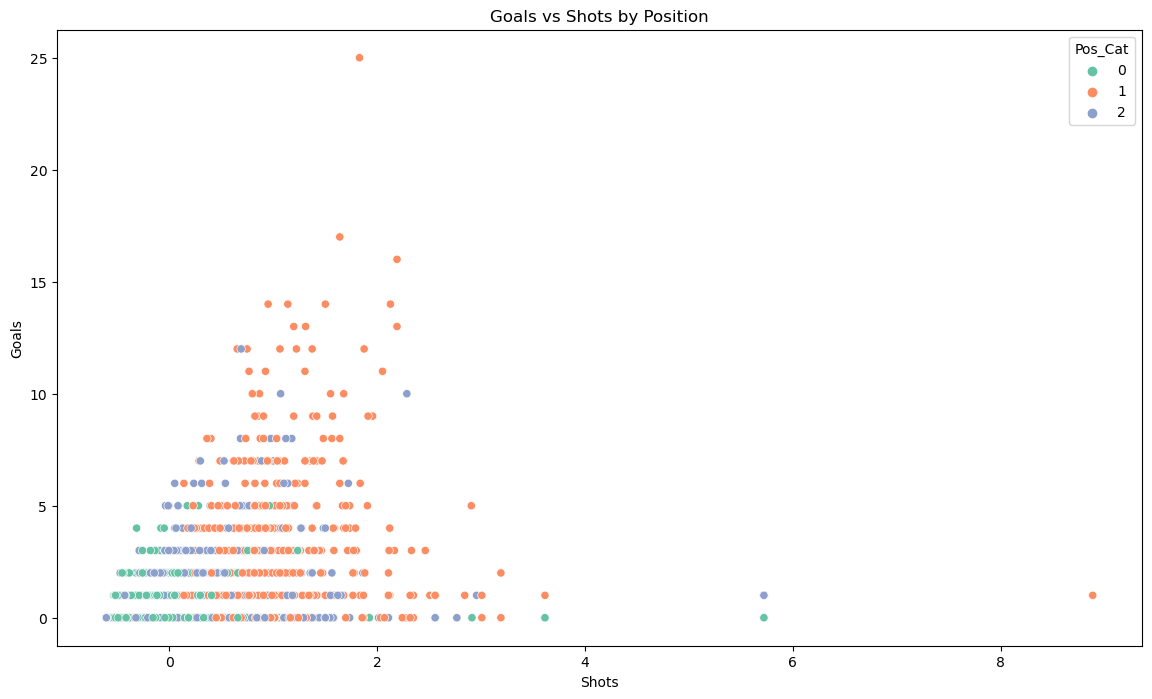

In [37]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=scaled_numeric_df, x='Shots', y='Goals', hue='Pos_Cat', palette='Set2')
plt.title('Goals vs Shots by Position')
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.show()

In [26]:
# Calculate correlation matrix
correlation_matrix = scaled_numeric_df.corr()

correlation_matrix

,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
Market Value Euro,1.000000,0.139496,0.286923,0.339961,0.447905,0.138930,0.114982,0.144634,0.175860,0.103496,0.026574,0.126360,0.119067,0.152422,0.128769,0.118394,0.054653,0.192930,0.187349,0.089783,0.069318,0.051397,0.004786,0.094695,0.124825,0.141933,0.105950,-0.014645,0.126414,0.149271,-0.059583,-0.000013,0.095428,0.078359,-0.013871,-0.095378,0.060601,0.046472,0.032884,0.056888,0.152422,0.017317,0.003232,0.148642,0.147273,0.013270,0.047312,0.056478,0.047278,0.017430,0.123224,0.128193,0.034787,0.027716,0.014368,0.060754,0.026303,-0.063769,-0.046029,-0.080045,-0.018729,0.001787,-0.058137,-0.073487,-0.053830,-0.044953,-0.049256,-0.026375,-0.050954,-0.082104,0.004310,0.124593,-0.040529,-0.032732,0.102965,0.147748,0.173641,0.124255,0.100859,0.098222,0.064376,0.164953,0.151999,0.156601,0.128300,0.087597,0.161449,0.015450,0.025661,0.216255,0.120362,-0.047486,-0.016429,-0.005454,-0.073757,0.031064,0.029053,-0.013871,-0.046029,0.061557,-0.049369,0.038228,-0.016515,-0.060702,-0.104235,0.057258,-0.014103,-0.020786,0.082831
Born,0.139496,1.000000,-0.219287,-0.217304,-0.084163,0.048642,0.054472,-0.036739,-0.082920,-0.110296,-0.048457,-0.105874,-0.127398,-0.100614,-0.107997,-0.123007,-0.171264,-0.054289,-0.049524,-0.089243,-0.094921,-0.159137,-0.175395,0.012677,-0.033262,-0.140688,0.004268,0.016811,-0.084007,-0.097215,-0.076404,-0.168581,-0.035886,-0.093729,-0.025600,-0.002079,-0.055505,-0.026514,-0.053225,-0.047274,-0.100614,-0.058236,0.057462,0.015745,0.005904,-0.064729,0.080218,0.018640,0.015538,0.021442,0.036713,0.027021,-0.046472,0.021473,0.026961,0.004662,0.007615,0.101689,0.095614,0.063014,0.066310,0.069226,0.021690,0.031188,0.026043,0.042433,-0.088285,0.084789,0.002044,-0.112367,-0.000091,-0.062422,-0.123527,-0.087828,-0.074567,0.074987,0.070913,-0.062047,0.213889,0.152022,0.191722,-0.014245,0.073199,0.043913,0.118538,0.066069,0.133708,0.137467,0.163235,-0.057076,0.114659,0.037254,-0.015672,-0.001606,0.060290,0.059450,-0.036435,-0.025600,0.095614,0.028498,0.004077,-0.017087,0.042172,-0.065115,0.032218,0.063239,0.032719,0.058844,0.019184
MP,0.286923,-0.219287,1.000000,0.902420,0.429168,0.007898,0.010656,0.186783,0.319424,0.416243,0.021592,0.131650,0.132473,0.080269,0.071698,0.089369,0.105057,0.072729,0.066234,0.054403,0.050776,0.109708,0.099012,0.049261,0.053634,0.150813,0.018721,-0.016391,0.108769,0.068253,0.038052,0.106641,0.014790,0.068318,0.007866,-0.020039,0.059094,0.030133,0.050810,0.063162,0.080269,-0.005893,-0.037485,0.039512,0.058512,0.046364,-0.037763,-0.038077,0.015800,-0.003218,0.050016,0.068842,0.090817,-0.014629,-0.036997,0.083747,0.065143,-0.089202,-0.084074,-0.087999,-0.027413,-0.043588,-0.041572,-0.078187,-0.078408,-0.051998,-0.001319,-0.055274,0.021830,-0.020064,-0.000476,0.036141,0.008287,0.011816,0.068585,-0.028527,-0.009606,0.035765,-0.087579,-0.072909,-0.071425,0.060210,0.034872,0.043405,-0.016370,-0.021261,0.006910,-0.083156,-0.097736,0.064521,-0.040791,-0.099104,-0.042121,-0.042028,-0.110766,-0.009883,-0.032809,0.007866,-0.084074,0.086043,-0.016285,0.036022,0.004320,-0.039973,-0.126331,0.019049,-0.001515,-0.015897,0.041182
90s,0.339961,-0.217304,0.902420,1.000000,0.423576,-0.085998,-0.048441,0.161682,0.286378,0.339776,0.016248,0

In [27]:
# Set the threshold for collinearity
threshold = 0.95

corr_matrix = scaled_numeric_df.corr().abs()

columns_to_keep = set(scaled_numeric_df.columns)

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            if colname_i in columns_to_keep and colname_j in columns_to_keep:
                columns_to_keep.remove(colname_j)

scaled_numeric_df = scaled_numeric_df[list(columns_to_keep)]

print(f"Dropped columns due to high correlation: {set(scaled_numeric_df.columns) - columns_to_keep}")
print(f"Remaining columns: {columns_to_keep}")

Dropped columns due to high correlation: set()
Remaining columns: {'PasCrs', 'SCA', 'Goals', 'RecProg', '90s', 'PasProg', 'ToSuc', 'Car3rd', 'Pas3rd', 'PasMedCmp', 'SoT', 'TouDefPen', 'ToTkl', 'Squad_Cat', 'CkIn', 'TklWon', 'TouDef3rd', 'TklAtt3rd', 'Fld', 'Touches', 'Market Value Euro', 'TouMid3rd', 'Born', 'Fls', 'CK', 'Assists', 'GcaDrib', 'Tkl', 'PKwon', 'PPA', 'Comp_Cat', 'ShoPK', 'BlkPass', 'ToAtt', 'TklDef3rd', 'TouAtt3rd', 'ScaDef', 'TklDriAtt', 'CarDis', 'Carries', 'CPA', '2CrdY', 'GcaPassLive', 'TI', 'CarMis', 'OG', 'CkStr', 'GcaDef', 'ScaSh', 'Int', 'CrsPA', 'Pos_Cat', 'Rec', 'Blocks', 'PasLonCmp', 'CrdY', 'PasFK', 'MP', 'GcaPassDead', 'PKatt', 'G/Sh', 'PKcon', 'ScaFld', 'CrdR', 'TB', 'Nation_Cat', 'PasLonAtt', 'ShoDist', 'ScaDrib', 'CarPrgDist', 'CkOut', 'PasShoCmp', 'GcaSh', 'ScaPassLive', 'Clr', 'PasTotCmp', 'ShoFK', 'TklMid3rd', 'PasBlocks', 'Recov', 'CarProg', 'CarTotDist', 'BlkSh', 'GcaFld', 'AerWon', 'PasAss', 'Sw', 'PasDead', 'PasTotPrgDist', 'ScaPassDead', 'TklDri',

In [40]:
scaled_numeric_df.head()

,PasLonCmp,PKwon,G/SoT,Born,TouAttPen,Assists,CarProg,GcaPassLive,90s,TouMid3rd,Pos_Cat,Goals,CrdR,PasDead,Market Value Euro,ShoPK,AerWon,PasLonAtt,PasMedCmp,Nation_Cat,BlkPass,PasFK,TklDri,PKcon,TklMid3rd,OG,Tkl,2CrdY,GcaSh,Err,GcaPassDead,GcaDef,TB,ShoDist,Clr,ToSuc,Carries,CkOut,CK,Squad_Cat,PasCrs,G/Sh,ToTkl,MP,PKatt,CrsPA,Sw,Rec,Pas3rd,BlkSh,TouDef3rd,SoT,Fls,CkStr,Blocks,Off,TouDefPen,Int,CarMis,PPA,CPA,TI,PasProg,ScaPassDead,ScaPassLive,TklDriAtt,ScaDef,CarTotDist,GCA,TklDriPast,ScaDrib,Fld,GcaFld,Shots,PasTotPrgDist,PasBlocks,Car3rd,TklWon,AerLost,ScaSh,Touches,CrdY,PasAss,CarPrgDist,CarDis,ScaFld,PasShoCmp,CkIn,PasOff,Recov,TklDef3rd,ToAtt,Comp_Cat,GcaDrib,TklAtt3rd,SCA,ShoFK,PasTotCmp,RecProg,TouAtt3rd
0,-0.500000,0.0,0.606061,0.428571,0.357934,0.916667,0.101010,0.500000,0.902655,-0.407871,2,1.0,0.0,0.178984,1.666667,0.0,-0.468531,-0.460076,-0.539496,98,1.208333,0.258741,-0.166667,0.0,0.501742,0.00,0.034965,0.0,0.06,0.06,0.0,0.06,1.307692,0.325843,-0.4175,0.813187,-0.238994,0.62,7.736842,44,0.657921,0.363636,1.000000,0.538462,0.0,0.392857,-0.340426,-0.213415,-0.235417,-0.071429,-0.498778,0.078125,-0.53,0.06,0.8375,0.708333,-0.465504,-0.674699,0.692737,-0.132653,0.426230,-0.025478,-0.041045,4.307692,0.617886,0.108527,0.06,-0.238848,0.5625,0.547945,2.090909,1.103448,0.0,0.360759,-0.458913,0.021505,-0.006944,-0.398922,0.016,0.578947,-0.464912,-0.133333,0.900901,-0.327115,1.862903,1.898305,-0.185567,0.68,-0.375000,-0.084291,-0.252632,1.086809,3,0.0,0.424242,0.785377,0.11,-0.434091,0.338652,0.515873
1,0.396875,0.0,0.000000,-1.428571,-0.158672,0.416667,-0.393939,0.363636,1.283186,0.343470,0,0.0,0.0,0.375289,-0.358333,0.0,0.818182,0.420152,0.911765,64,1.027778,1.909091,0.797619,0.0,0.641115,0.00,0.636364,0.0,0.05,0.05,0.0,0.00,0.000000,-0.292135,0.8975,-0.142857,0.597484,0.00,0.000000,73,-0.294652,0.000000,-0.168067,0.692308,0.0,0.000000,0.829787,0.048780,0.247917,1.500000,1.010595,-0.281250,0.17,0.00,1.5125,0.208333,1.302502,1.195181,-0.351955,-0.500000,-0.081967,-0.114650,0.436567,0.000000,-0.364228,0.271318,0.09,0.687279,0.2500,-0.273973,0.000000,-0.413793,0.0,-0.063291,0.876524,-0.258065,-0.590278,0.765499,0.048,0.947368,0.201754,-0.200000,-0.432432,0.859870,-0.096774,0.000000,-0.432990,0.00,0.583333,0.597701,0.800000,-0.288613,2,0.0,-0.272727,-0.384434,0.00,0.261364,-0.622340,-0.973810
2,0.600000,0.0,0.000000,0.285714,-0.132841,0.000000,0.621212,-0.272727,0.097345,0.808587,2,0.0,0.0,-0.218245,-0.208333,0.0,-0.055944,0.216730,0.264706,36,0.958333,-0.167832,1.166667,0.0,1.198606,0.00,0.923077,0.0,0.00,0.00,0.0,0.00,0.923077,0.348315,-0.0925,1.802198,1.132075,0.00,0.000000,2,0.056509,0.000000,0.798319,0.076923,0.0,1.250000,0.148936,0.591463,0.681250,-0.047619,-0.039120,0.187500,0.59,0.00,0.6125,0.000000,-0.304776,0.163855,0.407821,1.183673,0.540984,0.343949,1.145522,0.000000,0.663415,1.038760,0.12,1.294312,-0.3125,0.671233,0.000000,0.258621,0.0,0.056962,0.128496,0.354839,1.027778,0.560647,-0.096,0.631579,0.350877,-0.100000,0.684685,1.311063,0.201613,0.000000,0.350515,0.00,0.583333,1.172414,0.621053,1.136415,2,0.0,0.272727,0.337264,0.00,0.329545,0.388298,0.190476
3,0.265625,0.0,1.000000,0.428571,-0.302583,0.000000,-0.040404,-0.272727,1.106195,1.781753,2,1.0,0.0,-0.162818,0.666667,0.0,-0.356643,-0.093156,1.037815,41,0.333333,0.496503,0.238095,0.0,0.432056,0.05,-0.062937,0.0,0.00,0.00,0.0,0.00,0.384615,0.471910,-0.1575,0.274725,1.918239,0.00,0.000000,46,-0.226034,0.727273,-0.134454,0.538462,0.0,0.357143,0.085106,1.390244,1.535417,0.500000,0.000000,-0.125000,1.30,0.00,0.3500,0.000000,0.050038,0.327711,-0.005587,-0.030612,0.016393,-0.108280,0.847015,0.000000,-0.045528,-0.023256,0.05,1.468020,-0.3125,-0.150685,0.909091,0.318966,0.0,-0.227848,0.351068,-0.462366,0.604167,-0.086253,-0.536,0.526316,0.820175,0.000000,-0.225225,0.729718,0.403226,0.000000,1.494845,0.00,1.083333,0.582375,-0.147368,-0.031567,2,0.0,-0.121212,-0.167453,0.00,1.215909,-0.361702,-0.222222
4,0.043750,0.0,0.000000,-0.571429,-0.476015,0.666667,-0.434343,0.09090

In [41]:
scaled_numeric_df.head()

,PasLonCmp,PKwon,G/SoT,Born,TouAttPen,Assists,CarProg,GcaPassLive,90s,TouMid3rd,Pos_Cat,Goals,CrdR,PasDead,Market Value Euro,ShoPK,AerWon,PasLonAtt,PasMedCmp,Nation_Cat,BlkPass,PasFK,TklDri,PKcon,TklMid3rd,OG,Tkl,2CrdY,GcaSh,Err,GcaPassDead,GcaDef,TB,ShoDist,Clr,ToSuc,Carries,CkOut,CK,Squad_Cat,PasCrs,G/Sh,ToTkl,MP,PKatt,CrsPA,Sw,Rec,Pas3rd,BlkSh,TouDef3rd,SoT,Fls,CkStr,Blocks,Off,TouDefPen,Int,CarMis,PPA,CPA,TI,PasProg,ScaPassDead,ScaPassLive,TklDriAtt,ScaDef,CarTotDist,GCA,TklDriPast,ScaDrib,Fld,GcaFld,Shots,PasTotPrgDist,PasBlocks,Car3rd,TklWon,AerLost,ScaSh,Touches,CrdY,PasAss,CarPrgDist,CarDis,ScaFld,PasShoCmp,CkIn,PasOff,Recov,TklDef3rd,ToAtt,Comp_Cat,GcaDrib,TklAtt3rd,SCA,ShoFK,PasTotCmp,RecProg,TouAtt3rd
0,-0.500000,0.0,0.606061,0.428571,0.357934,0.916667,0.101010,0.500000,0.902655,-0.407871,2,1.0,0.0,0.178984,1.666667,0.0,-0.468531,-0.460076,-0.539496,98,1.208333,0.258741,-0.166667,0.0,0.501742,0.00,0.034965,0.0,0.06,0.06,0.0,0.06,1.307692,0.325843,-0.4175,0.813187,-0.238994,0.62,7.736842,44,0.657921,0.363636,1.000000,0.538462,0.0,0.392857,-0.340426,-0.213415,-0.235417,-0.071429,-0.498778,0.078125,-0.53,0.06,0.8375,0.708333,-0.465504,-0.674699,0.692737,-0.132653,0.426230,-0.025478,-0.041045,4.307692,0.617886,0.108527,0.06,-0.238848,0.5625,0.547945,2.090909,1.103448,0.0,0.360759,-0.458913,0.021505,-0.006944,-0.398922,0.016,0.578947,-0.464912,-0.133333,0.900901,-0.327115,1.862903,1.898305,-0.185567,0.68,-0.375000,-0.084291,-0.252632,1.086809,3,0.0,0.424242,0.785377,0.11,-0.434091,0.338652,0.515873
1,0.396875,0.0,0.000000,-1.428571,-0.158672,0.416667,-0.393939,0.363636,1.283186,0.343470,0,0.0,0.0,0.375289,-0.358333,0.0,0.818182,0.420152,0.911765,64,1.027778,1.909091,0.797619,0.0,0.641115,0.00,0.636364,0.0,0.05,0.05,0.0,0.00,0.000000,-0.292135,0.8975,-0.142857,0.597484,0.00,0.000000,73,-0.294652,0.000000,-0.168067,0.692308,0.0,0.000000,0.829787,0.048780,0.247917,1.500000,1.010595,-0.281250,0.17,0.00,1.5125,0.208333,1.302502,1.195181,-0.351955,-0.500000,-0.081967,-0.114650,0.436567,0.000000,-0.364228,0.271318,0.09,0.687279,0.2500,-0.273973,0.000000,-0.413793,0.0,-0.063291,0.876524,-0.258065,-0.590278,0.765499,0.048,0.947368,0.201754,-0.200000,-0.432432,0.859870,-0.096774,0.000000,-0.432990,0.00,0.583333,0.597701,0.800000,-0.288613,2,0.0,-0.272727,-0.384434,0.00,0.261364,-0.622340,-0.973810
2,0.600000,0.0,0.000000,0.285714,-0.132841,0.000000,0.621212,-0.272727,0.097345,0.808587,2,0.0,0.0,-0.218245,-0.208333,0.0,-0.055944,0.216730,0.264706,36,0.958333,-0.167832,1.166667,0.0,1.198606,0.00,0.923077,0.0,0.00,0.00,0.0,0.00,0.923077,0.348315,-0.0925,1.802198,1.132075,0.00,0.000000,2,0.056509,0.000000,0.798319,0.076923,0.0,1.250000,0.148936,0.591463,0.681250,-0.047619,-0.039120,0.187500,0.59,0.00,0.6125,0.000000,-0.304776,0.163855,0.407821,1.183673,0.540984,0.343949,1.145522,0.000000,0.663415,1.038760,0.12,1.294312,-0.3125,0.671233,0.000000,0.258621,0.0,0.056962,0.128496,0.354839,1.027778,0.560647,-0.096,0.631579,0.350877,-0.100000,0.684685,1.311063,0.201613,0.000000,0.350515,0.00,0.583333,1.172414,0.621053,1.136415,2,0.0,0.272727,0.337264,0.00,0.329545,0.388298,0.190476
3,0.265625,0.0,1.000000,0.428571,-0.302583,0.000000,-0.040404,-0.272727,1.106195,1.781753,2,1.0,0.0,-0.162818,0.666667,0.0,-0.356643,-0.093156,1.037815,41,0.333333,0.496503,0.238095,0.0,0.432056,0.05,-0.062937,0.0,0.00,0.00,0.0,0.00,0.384615,0.471910,-0.1575,0.274725,1.918239,0.00,0.000000,46,-0.226034,0.727273,-0.134454,0.538462,0.0,0.357143,0.085106,1.390244,1.535417,0.500000,0.000000,-0.125000,1.30,0.00,0.3500,0.000000,0.050038,0.327711,-0.005587,-0.030612,0.016393,-0.108280,0.847015,0.000000,-0.045528,-0.023256,0.05,1.468020,-0.3125,-0.150685,0.909091,0.318966,0.0,-0.227848,0.351068,-0.462366,0.604167,-0.086253,-0.536,0.526316,0.820175,0.000000,-0.225225,0.729718,0.403226,0.000000,1.494845,0.00,1.083333,0.582375,-0.147368,-0.031567,2,0.0,-0.121212,-0.167453,0.00,1.215909,-0.361702,-0.222222
4,0.043750,0.0,0.000000,-0.571429,-0.476015,0.666667,-0.434343,0.09090

# Machine Learning

In [28]:
# Separate data for classification
X = scaled_numeric_df.drop(['Pos_Cat'], axis=1)
y_pos_cat = scaled_numeric_df['Pos_Cat']

In [29]:
# Split data into training and testing sets
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

## Random Forest Train and Test

In [30]:
rf_pos_cat = RandomForestClassifier(n_estimators=100, random_state=random_seed)

In [31]:
rf_pos_cat.fit(X_train_pos, y_train_pos)

RandomForestClassifier(random_state=42)

Classification Report for Pos_Cat Prediction:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       182
           1       0.79      0.79      0.79       131
           2       0.82      0.80      0.81       176

    accuracy                           0.86       489
   macro avg       0.85      0.85      0.85       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix:
[[174   1   7]
 [  2 104  25]
 [  8  27 141]]
Accuracy: 0.86
Precision (Macro Average): 0.85
Recall (Macro Average): 0.85
F1 Score (Macro Average): 0.85
ROC AUC Score: 0.96


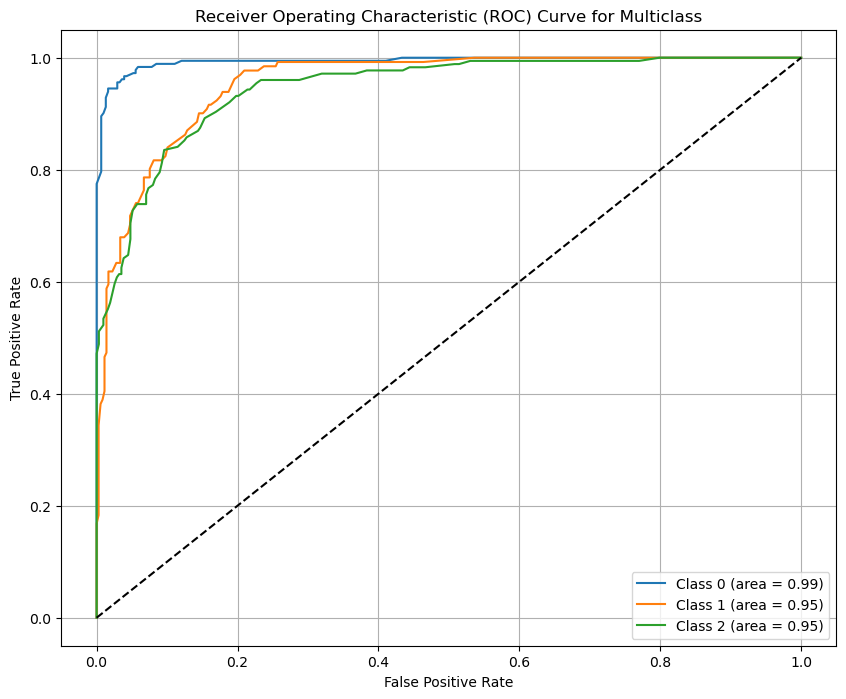

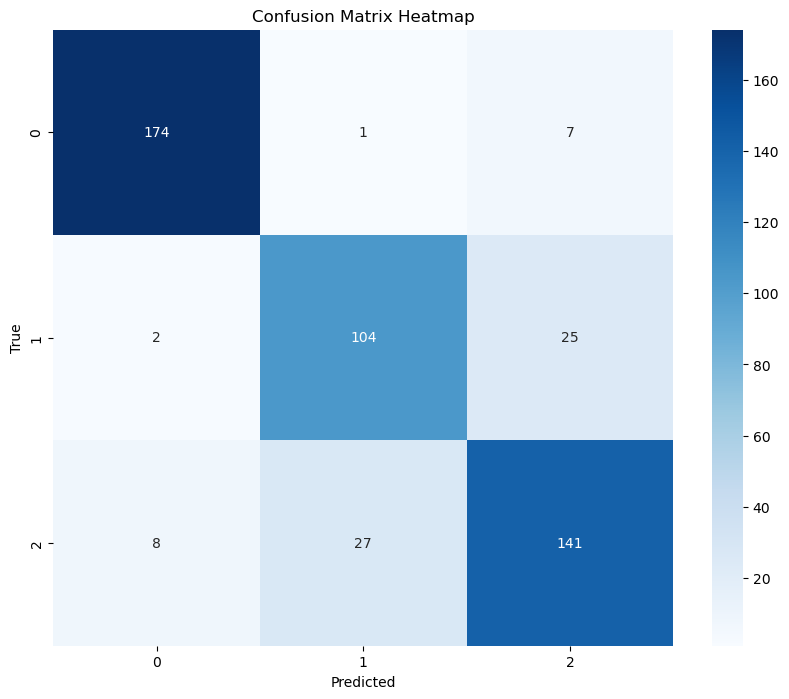

In [33]:
y_pred_pos = rf_pos_cat.predict(X_test_pos)
y_proba_pos = rf_pos_cat.predict_proba(X_test_pos)

# Classification report
print("Classification Report for Pos_Cat Prediction:")
print(classification_report(y_test_pos, y_pred_pos, zero_division=1, digits=2))

# confusion matrix
cm = confusion_matrix(y_test_pos, y_pred_pos)
print("Confusion Matrix:")
print(cm)

# calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_pos)
precision = precision_score(y_test_pos, y_pred_pos, average='macro')
recall = recall_score(y_test_pos, y_pred_pos, average='macro')
f1 = f1_score(y_test_pos, y_pred_pos, average='macro')

y_test_binarized = label_binarize(y_test_pos, classes=np.unique(y_test_pos))

# compute ROC AUC scores
try:
    roc_auc = roc_auc_score(y_test_binarized, y_proba_pos, average='macro', multi_class='ovr')
except ValueError:
    roc_auc = 'Cannot compute AUC for multiclass with the current settings.'

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro Average): {precision:.2f}")
print(f"Recall (Macro Average): {recall:.2f}")
print(f"F1 Score (Macro Average): {f1:.2f}")
print(f"ROC AUC Score: {roc_auc if isinstance(roc_auc, str) else f'{roc_auc:.2f}'}")

n_classes = y_proba_pos.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_pos[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_pos), yticklabels=np.unique(y_test_pos))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Hyperparameter Tuning for RF

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       182
           1       0.81      0.77      0.79       131
           2       0.81      0.82      0.82       176

    accuracy                           0.86       489
   macro avg       0.86      0.85      0.86       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best Model:
[[176   0   6]
 [  2 101  28]
 [  7  24 145]]
Accuracy: 0.86
Precision (Macro Average): 0.86
Recall (Macro Average): 0.85
F1 Score (Macro Average): 0.86
ROC AUC Score: 0.97


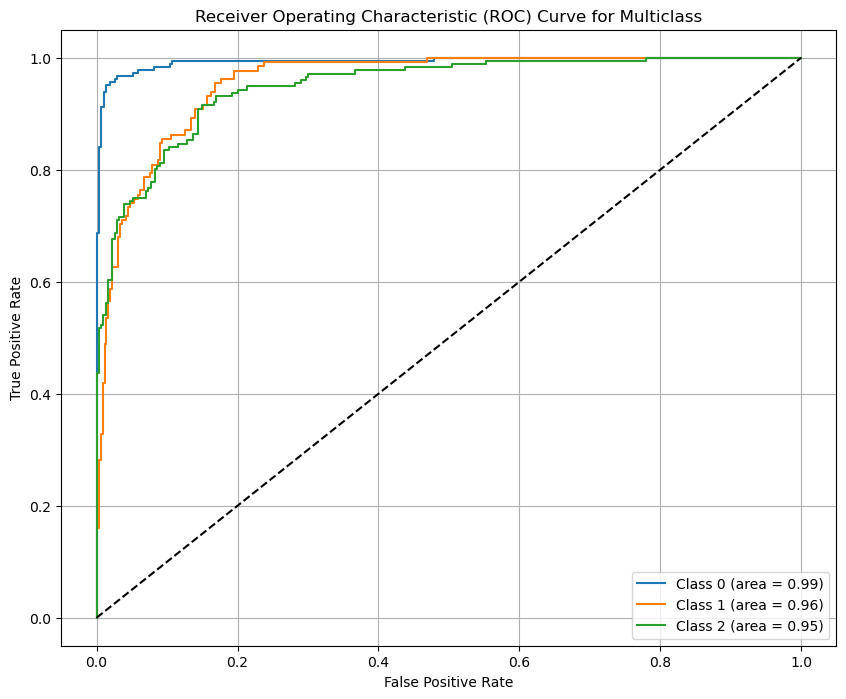

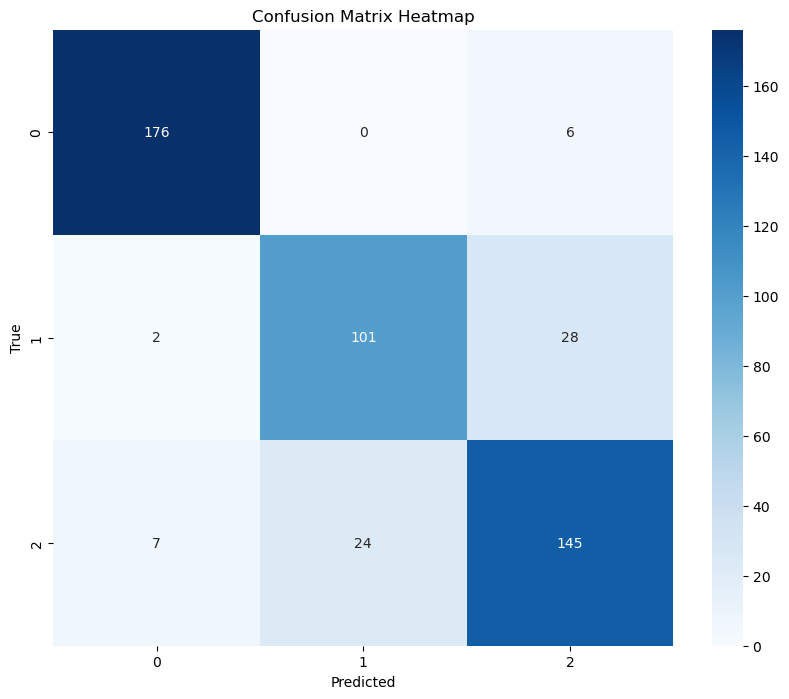

In [34]:
# random seed for reproducibility
random_seed = 42

# best parameters for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# grid search to find best parameters
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=random_seed),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_pos, y_train_pos)

# print best parameters
print("Best Parameters:", grid_search.best_params_)

# best rf model
best_rf_pos_cat = grid_search.best_estimator_

y_pred_best = best_rf_pos_cat.predict(X_test_pos)
y_proba_best = best_rf_pos_cat.predict_proba(X_test_pos)

print("Classification Report for Best Model:")
print(classification_report(y_test_pos, y_pred_best, zero_division=1, digits=2))

cm_best = confusion_matrix(y_test_pos, y_pred_best)
print("Confusion Matrix for Best Model:")
print(cm_best)

accuracy = accuracy_score(y_test_pos, y_pred_best)
precision = precision_score(y_test_pos, y_pred_best, average='macro')
recall = recall_score(y_test_pos, y_pred_best, average='macro')
f1 = f1_score(y_test_pos, y_pred_best, average='macro')

y_test_binarized = label_binarize(y_test_pos, classes=np.unique(y_test_pos))

# compute roc auc score
try:
    roc_auc = roc_auc_score(y_test_binarized, y_proba_best, multi_class='ovr')
except ValueError:
    roc_auc = 'Cannot compute AUC for multiclass with the current settings.'

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro Average): {precision:.2f}")
print(f"Recall (Macro Average): {recall:.2f}")
print(f"F1 Score (Macro Average): {f1:.2f}")
print(f"ROC AUC Score: {roc_auc if isinstance(roc_auc, str) else f'{roc_auc:.2f}'}")

n_classes = y_proba_best.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_best[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_pos), yticklabels=np.unique(y_test_pos))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Feature importance analysis

Total number of features used for training/testing: 99
Classification Report for Best Model with Top 99 Features:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       182
           1       0.80      0.80      0.80       131
           2       0.82      0.81      0.82       176

    accuracy                           0.86       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best Model with Top 99 Features:
[[174   2   6]
 [  1 105  25]
 [  8  25 143]]


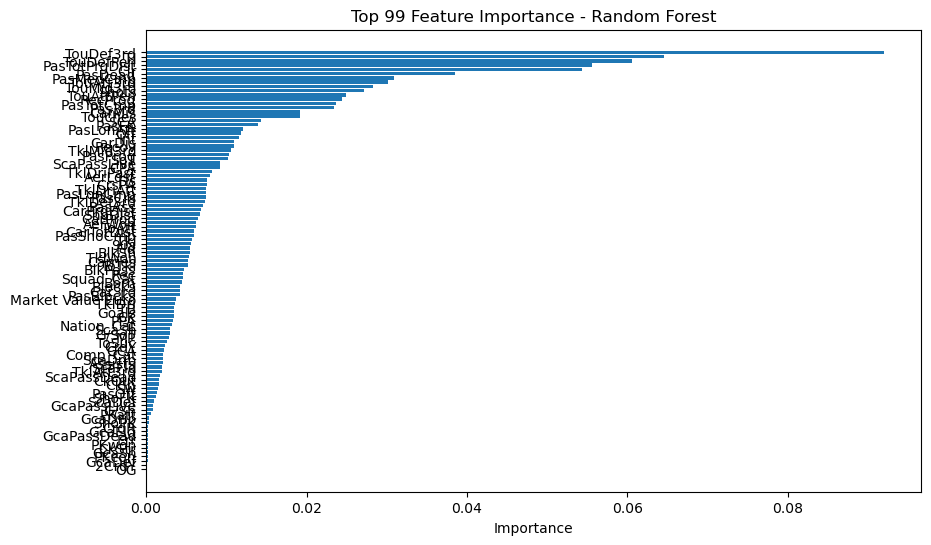

Total number of features used for training/testing: 98
Classification Report for Best Model with Top 98 Features:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       182
           1       0.80      0.79      0.80       131
           2       0.83      0.82      0.83       176

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

Confusion Matrix for Best Model with Top 98 Features:
[[175   2   5]
 [  2 104  25]
 [  7  24 145]]


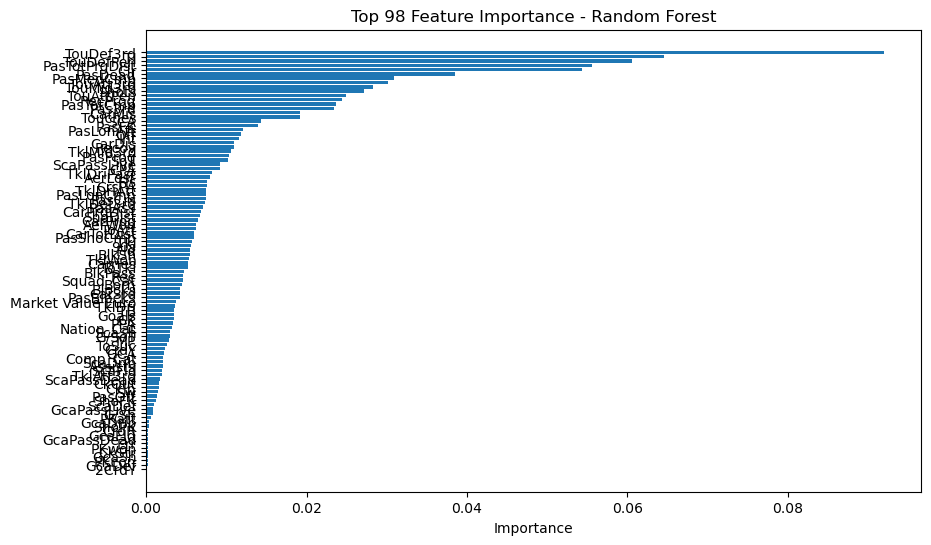

Performance change is less than the tolerance (0.01), continuing to test lower feature counts...

Performance Metrics Across Feature Reductions:
    feature_count  accuracy        f1  precision    recall   roc_auc
0              99  0.862986  0.856349   0.856038  0.856690  0.967225
1              98  0.867076  0.859810   0.859886  0.859765  0.964890
2              97  0.865031  0.857911   0.857981  0.857871  0.965686
3              96  0.862986  0.856236   0.855467  0.857278  0.965771
4              95  0.860941  0.853061   0.853289  0.852845  0.962428
5              94  0.858896  0.852063   0.853448  0.850951  0.966322
6              93  0.867076  0.859871   0.861645  0.858526  0.962481
7              92  0.862986  0.855445   0.857245  0.854088  0.964659
8              91  0.858896  0.850867   0.852483  0.849649  0.966588
9              90  0.877301  0.870939   0.871383  0.870536  0.968407
10             89  0.860941  0.854122   0.853569  0.854796  0.967640
11             88  0.881391

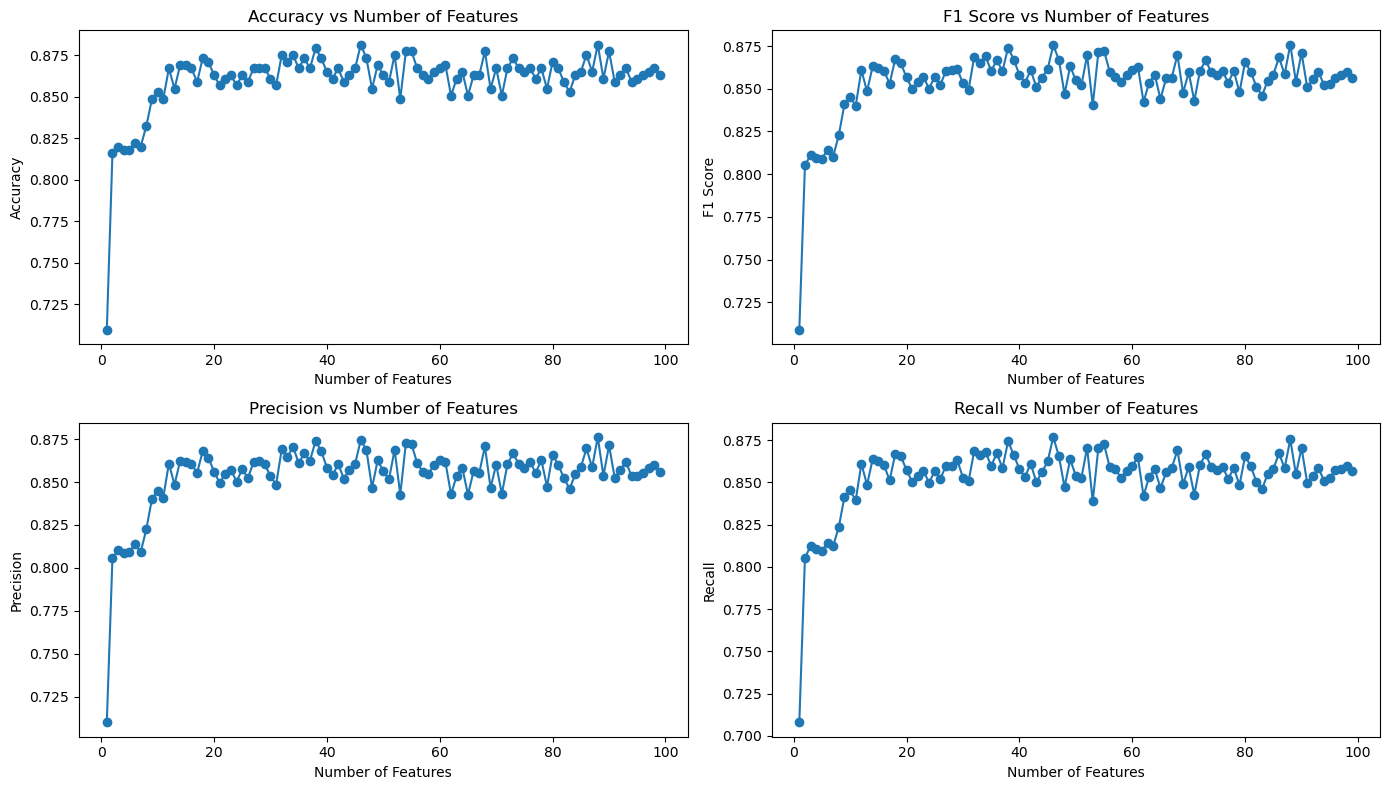

In [36]:
# random seed for reproducibility
random_seed = 42

# best parameters for random forest
best_params = {
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 50,
    'random_state': random_seed 
}

best_rf_pos_cat = RandomForestClassifier(**best_params)
best_rf_pos_cat.fit(X_train_pos, y_train_pos)

# calculate feature importances
importances = best_rf_pos_cat.feature_importances_
feature_names = X_train_pos.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# feature reductions
previous_performance = None
tolerance = 0.01  
min_features = 1  

performance_metrics = {
    'feature_count': [],
    'accuracy': [],
    'f1': [],
    'precision': [],
    'recall': [],
    'roc_auc': []
}


y_test_binarized = label_binarize(y_test_pos, classes=np.unique(y_train_pos))


for n in range(len(feature_names), min_features - 1, -1):
    
    
    top_n_features = feature_importances.head(n)['Feature'].values

   
    X_train_top_n = X_train_pos[top_n_features]
    X_test_top_n = X_test_pos[top_n_features]

   
    best_rf_pos_cat_top_n = RandomForestClassifier(**best_params)
    best_rf_pos_cat_top_n.fit(X_train_top_n, y_train_pos)

   
    y_pred_best_top_n = best_rf_pos_cat_top_n.predict(X_test_top_n)
    y_pred_prob_best_top_n = best_rf_pos_cat_top_n.predict_proba(X_test_top_n)

  
    current_accuracy = accuracy_score(y_test_pos, y_pred_best_top_n)
    current_f1 = f1_score(y_test_pos, y_pred_best_top_n, average='macro')
    current_precision = precision_score(y_test_pos, y_pred_best_top_n, average='macro')
    current_recall = recall_score(y_test_pos, y_pred_best_top_n, average='macro')
    try:
        current_roc_auc = roc_auc_score(y_test_binarized, y_pred_prob_best_top_n, average='macro', multi_class='ovo')
    except ValueError:
        current_roc_auc = 'Cannot compute AUC for multiclass with the current settings.'

    
    performance_metrics['feature_count'].append(n)
    performance_metrics['accuracy'].append(current_accuracy)
    performance_metrics['f1'].append(current_f1)
    performance_metrics['precision'].append(current_precision)
    performance_metrics['recall'].append(current_recall)
    performance_metrics['roc_auc'].append(current_roc_auc)

    
    print(f'Total number of features used for training/testing: {n}')
    print(f"Classification Report for Best Model with Top {n} Features:")
    print(classification_report(y_test_pos, y_pred_best_top_n, zero_division=1))
    cm_best_top_n = confusion_matrix(y_test_pos, y_pred_best_top_n)
    print(f"Confusion Matrix for Best Model with Top {n} Features:")
    print(cm_best_top_n)

    
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_features, feature_importances[feature_importances['Feature'].isin(top_n_features)]['Importance'], align='center')
    plt.xlabel('Importance')
    plt.title(f'Top {n} Feature Importance - Random Forest')
    plt.gca().invert_yaxis()
    plt.show()

    
    if previous_performance is not None:
        if (abs(current_accuracy - previous_performance['accuracy']) < tolerance and
            abs(current_f1 - previous_performance['f1']) < tolerance and
            abs(current_precision - previous_performance['precision']) < tolerance and
            abs(current_recall - previous_performance['recall']) < tolerance and
            abs(current_roc_auc - previous_performance['roc_auc']) < tolerance):
            
            print(f"Performance change is less than the tolerance ({tolerance}), continuing to test lower feature counts...")

            # test the models with less features if within tolerance
            for test_n in range(n - 1, min_features - 1, -1):
                top_test_features = feature_importances.head(test_n)['Feature'].values
                X_train_test = X_train_pos[top_test_features]
                X_test_test = X_test_pos[top_test_features]
                model = RandomForestClassifier(**best_params)
                model.fit(X_train_test, y_train_pos)
                y_pred_test = model.predict(X_test_test)
                y_pred_prob_test = model.predict_proba(X_test_test)
                accuracy_test = accuracy_score(y_test_pos, y_pred_test)
                f1_test = f1_score(y_test_pos, y_pred_test, average='macro')
                precision_test = precision_score(y_test_pos, y_pred_test, average='macro')
                recall_test = recall_score(y_test_pos, y_pred_test, average='macro')
                roc_auc_test = roc_auc_score(y_test_binarized, y_pred_prob_test, average='macro', multi_class='ovo')
                performance_metrics['feature_count'].append(test_n)
                performance_metrics['accuracy'].append(accuracy_test)
                performance_metrics['f1'].append(f1_test)
                performance_metrics['precision'].append(precision_test)
                performance_metrics['recall'].append(recall_test)
                performance_metrics['roc_auc'].append(roc_auc_test)
            break

    
    previous_performance = {
        'accuracy': current_accuracy,
        'f1': current_f1,
        'precision': current_precision,
        'recall': current_recall,
        'roc_auc': current_roc_auc
    }


performance_df = pd.DataFrame(performance_metrics)
print("\nPerformance Metrics Across Feature Reductions:")
print(performance_df)

# plot the performance metrics vs number of features
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(performance_df['feature_count'], performance_df['accuracy'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')

plt.subplot(2, 2, 2)
plt.plot(performance_df['feature_count'], performance_df['f1'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Features')

plt.subplot(2, 2, 3)
plt.plot(performance_df['feature_count'], performance_df['precision'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Precision')
plt.title('Precision vs Number of Features')

plt.subplot(2, 2, 4)
plt.plot(performance_df['feature_count'], performance_df['recall'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.title('Recall vs Number of Features')

plt.tight_layout()
plt.show()

Total number of features in the original dataset: 99.00
Total number of features used for training/testing: 19.00
Classification Report for Best Model with Top 17 Features:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       182
           1       0.80      0.82      0.81       131
           2       0.84      0.82      0.83       176

    accuracy                           0.87       489
   macro avg       0.86      0.87      0.86       489
weighted avg       0.87      0.87      0.87       489

Confusion Matrix for Best Model with Top 17 Features:
[[175   0   7]
 [  3 107  21]
 [  6  26 144]]
ROC AUC Score: 0.97
F1 Score: 0.87


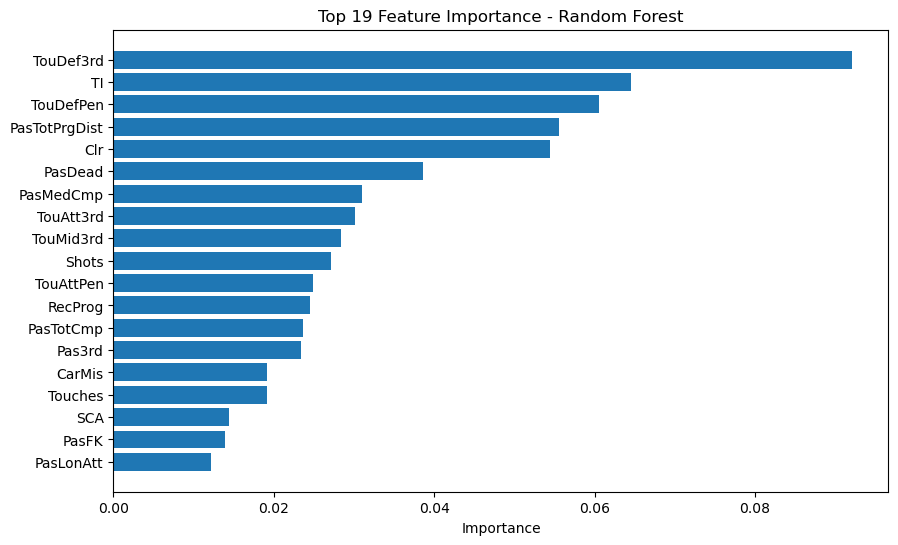

In [37]:
# random seed for reproducibility
random_seed = 42  

# best parameters
best_params = {
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 50,
    'random_state': random_seed 
}


best_rf_pos_cat = RandomForestClassifier(**best_params)
best_rf_pos_cat.fit(X_train_pos, y_train_pos)


importances = best_rf_pos_cat.feature_importances_
feature_names = X_train_pos.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


total_features = X_train_pos.shape[1]
print(f'Total number of features in the original dataset: {total_features:.2f}')

# number of features used
n = 19  
top_n_features = feature_importances.head(n)['Feature'].values
print(f'Total number of features used for training/testing: {len(top_n_features):.2f}')


X_train_top_n = X_train_pos[top_n_features]
X_test_top_n = X_test_pos[top_n_features]


best_rf_pos_cat_top_n = RandomForestClassifier(**best_params)
best_rf_pos_cat_top_n.fit(X_train_top_n, y_train_pos)


y_pred_best_top_n = best_rf_pos_cat_top_n.predict(X_test_top_n)
y_prob_best_top_n = best_rf_pos_cat_top_n.predict_proba(X_test_top_n)[:, 1]  

print("Classification Report for Best Model with Top 17 Features:")
print(classification_report(y_test_pos, y_pred_best_top_n, digits=2))

cm_best_top_n = confusion_matrix(y_test_pos, y_pred_best_top_n)
print("Confusion Matrix for Best Model with Top 17 Features:")
print(cm_best_top_n)


if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_n)
    print(f'ROC AUC Score: {roc_auc:.2f}')
else:  
    roc_auc = roc_auc_score(y_test_pos, best_rf_pos_cat_top_n.predict_proba(X_test_top_n), multi_class='ovr')
    print(f'ROC AUC Score: {roc_auc:.2f}')


f1 = f1_score(y_test_pos, y_pred_best_top_n, average='weighted')
print(f'F1 Score: {f1:.2f}')


plt.figure(figsize=(10, 6))
plt.barh(top_n_features, feature_importances[feature_importances['Feature'].isin(top_n_features)]['Importance'], align='center')
plt.xlabel('Importance')
plt.title(f'Top {len(top_n_features)} Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Other models and best parameters

## Logistic regression

In [38]:
# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

lr_model = LogisticRegression(max_iter=50, random_state=random_seed)
lr_model.fit(X_train_pos, y_train_pos)

y_pred_lr = lr_model.predict(X_test_pos)
y_prob_lr = lr_model.predict_proba(X_test_pos)[:, 1]

accuracy = accuracy_score(y_test_pos, y_pred_lr)
f1 = f1_score(y_test_pos, y_pred_lr, average='weighted')
precision = precision_score(y_test_pos, y_pred_lr, average='weighted')
recall = recall_score(y_test_pos, y_pred_lr, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_lr)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, lr_model.predict_proba(X_test_pos), multi_class='ovr')

print("Logistic Regression Classification Report:")
print(classification_report(y_test_pos, y_pred_lr, digits=2))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_lr))
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       182
           1       0.75      0.79      0.77       131
           2       0.83      0.77      0.80       176

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Logistic Regression Confusion Matrix:
[[176   3   3]
 [  3 103  25]
 [  8  32 136]]
Accuracy: 0.85
F1 Score: 0.85
Precision: 0.85
Recall: 0.85
ROC AUC Score: 0.96


C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

# find best parameters for logistic regression
param_grid = {
    'C': np.logspace(-4, 4, 20),  
    'solver': ['liblinear', 'lbfgs'],  
    'penalty': ['l1', 'l2']  
}


lr_model = LogisticRegression(max_iter=100, random_state=random_seed)


grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')


grid_search.fit(X_train_pos, y_train_pos)


best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")


best_lr_model = grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_pos)
y_prob_lr = best_lr_model.predict_proba(X_test_pos)[:, 1]


accuracy = accuracy_score(y_test_pos, y_pred_lr)
f1 = f1_score(y_test_pos, y_pred_lr, average='weighted')
precision = precision_score(y_test_pos, y_pred_lr, average='weighted')
recall = recall_score(y_test_pos, y_pred_lr, average='weighted')


if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_lr)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_lr_model.predict_proba(X_test_pos), multi_class='ovr')


print("Classification Report for Best Logistic Regression Model:")
print(classification_report(y_test_pos, y_pred_lr))

print("Confusion Matrix for Best Logistic Regression Model:")
print(confusion_matrix(y_test_pos, y_pred_lr))


print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\firda\AppData\Roaming\Python\Python311\sit

Best Parameters Found:
{'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8786
Classification Report for Best Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       182
           1       0.76      0.82      0.79       131
           2       0.84      0.80      0.82       176

    accuracy                           0.86       489
   macro avg       0.85      0.86      0.86       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best Logistic Regression Model:
[[175   2   5]
 [  3 107  21]
 [  5  31 140]]
Accuracy: 0.86
F1 Score: 0.86
Precision: 0.86
Recall: 0.86
ROC AUC Score: 0.96


In [47]:
# random seed for reproducibility
random_seed = 42

# number of features used
n = 19  
top_n_features = feature_importances.head(n)['Feature'].values

X_train_top_n = X_train_pos[top_n_features]
X_test_top_n = X_test_pos[top_n_features]


best_lr_params = {'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}

best_lr_pos_cat_top_n = LogisticRegression(**best_lr_params, random_state=random_seed)
best_lr_pos_cat_top_n.fit(X_train_top_n, y_train_pos)

y_pred_best_top_n = best_lr_pos_cat_top_n.predict(X_test_top_n)
y_prob_best_top_n = best_lr_pos_cat_top_n.predict_proba(X_test_top_n)[:, 1]

accuracy = accuracy_score(y_test_pos, y_pred_best_top_n)
f1 = f1_score(y_test_pos, y_pred_best_top_n, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_n, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_n, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_n)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_lr_pos_cat_top_n.predict_proba(X_test_top_n), multi_class='ovr')

print("Classification Report for Best Logistic Regression Model with Top n Features:")
print(classification_report(y_test_pos, y_pred_best_top_n))

print("Confusion Matrix for Best Logistic Regression Model with Top n Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_n))

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Classification Report for Best Logistic Regression Model with Top n Features:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       182
           1       0.76      0.84      0.80       131
           2       0.85      0.78      0.82       176

    accuracy                           0.86       489
   macro avg       0.85      0.86      0.85       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best Logistic Regression Model with Top n Features:
[[172   3   7]
 [  4 110  17]
 [  7  31 138]]
Accuracy: 0.86
F1 Score: 0.86
Precision: 0.86
Recall: 0.86
ROC AUC Score: 0.96


## KNN

In [41]:
# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train_pos, y_train_pos)

y_pred_knn = knn_model.predict(X_test_pos)
y_prob_knn = knn_model.predict_proba(X_test_pos)[:, 1]  

# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_knn)
f1 = f1_score(y_test_pos, y_pred_knn, average='weighted')
precision = precision_score(y_test_pos, y_pred_knn, average='weighted')
recall = recall_score(y_test_pos, y_pred_knn, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_knn)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, knn_model.predict_proba(X_test_pos), multi_class='ovr')

print("KNN Classification Report:")
print(classification_report(y_test_pos, y_pred_knn))

print("KNN Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_knn))

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       182
           1       0.67      0.55      0.61       131
           2       0.61      0.56      0.58       176

    accuracy                           0.67       489
   macro avg       0.66      0.66      0.66       489
weighted avg       0.66      0.67      0.66       489

KNN Confusion Matrix:
[[157   5  20]
 [ 16  72  43]
 [ 48  30  98]]
Accuracy: 0.67
F1 Score: 0.66
Precision: 0.66
Recall: 0.67
ROC AUC Score: 0.84


In [42]:
# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

# find best parameters for KNN
param_grid = {
    'n_neighbors': list(range(1, 21)),  
    'weights': ['uniform', 'distance'],  
    'p': [1, 2]  
}

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train_pos, y_train_pos)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

best_knn_model = grid_search.best_estimator_

y_pred_knn = best_knn_model.predict(X_test_pos)
y_prob_knn = best_knn_model.predict_proba(X_test_pos)[:, 1]  

accuracy = accuracy_score(y_test_pos, y_pred_knn)
f1 = f1_score(y_test_pos, y_pred_knn, average='weighted')
precision = precision_score(y_test_pos, y_pred_knn, average='weighted')
recall = recall_score(y_test_pos, y_pred_knn, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_knn)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_knn_model.predict_proba(X_test_pos), multi_class='ovr')

print("Classification Report for Best KNN Model:")
print(classification_report(y_test_pos, y_pred_knn))

print("Confusion Matrix for Best KNN Model:")
print(confusion_matrix(y_test_pos, y_pred_knn))

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Best Parameters Found:
{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.8039
Classification Report for Best KNN Model:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       182
           1       0.77      0.68      0.72       131
           2       0.73      0.70      0.71       176

    accuracy                           0.79       489
   macro avg       0.79      0.78      0.78       489
weighted avg       0.79      0.79      0.79       489

Confusion Matrix for Best KNN Model:
[[175   0   7]
 [  3  89  39]
 [ 27  26 123]]
Accuracy: 0.79
F1 Score: 0.79
Precision: 0.79
Recall: 0.79
ROC AUC Score: 0.93


In [60]:
# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

# number of features used
n =19
top_n_features = feature_importances.head(n)['Feature'].values

X_train_top_n = X_train_pos[top_n_features]
X_test_top_n = X_test_pos[top_n_features]

best_knn_params = {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}

best_knn_pos_cat_top_n = KNeighborsClassifier(**best_knn_params)
best_knn_pos_cat_top_n.fit(X_train_top_n, y_train_pos)

y_pred_best_top_n = best_knn_pos_cat_top_n.predict(X_test_top_n)
y_prob_best_top_n = best_knn_pos_cat_top_n.predict_proba(X_test_top_n)[:, 1]  

# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_n)
f1 = f1_score(y_test_pos, y_pred_best_top_n, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_n, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_n, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_n)
else:  
    from sklearn.preprocessing import label_binarize
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_knn_pos_cat_top_n.predict_proba(X_test_top_n), multi_class='ovr')

print("Classification Report for Best KNN Model with Top Features:")
print(classification_report(y_test_pos, y_pred_best_top_n))

print("Confusion Matrix for Best KNN Model with Top Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_n))

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Classification Report for Best KNN Model with Top Features:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       182
           1       0.80      0.80      0.80       131
           2       0.82      0.82      0.82       176

    accuracy                           0.86       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best KNN Model with Top Features:
[[172   2   8]
 [  2 105  24]
 [  7  24 145]]
Accuracy: 0.86
F1 Score: 0.86
Precision: 0.86
Recall: 0.86
ROC AUC Score: 0.97


## Gradient Boosting

In [44]:
# import gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=random_seed)
gb_model.fit(X_train_pos, y_train_pos)

y_pred_gb = gb_model.predict(X_test_pos)
y_prob_gb = gb_model.predict_proba(X_test_pos)[:, 1]

# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_gb)
f1 = f1_score(y_test_pos, y_pred_gb, average='weighted')
precision = precision_score(y_test_pos, y_pred_gb, average='weighted')
recall = recall_score(y_test_pos, y_pred_gb, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_gb)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, gb_model.predict_proba(X_test_pos), multi_class='ovr')

print("Gradient Boosting Classification Report:")
print(classification_report(y_test_pos, y_pred_gb))

print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_gb))

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       182
           1       0.81      0.79      0.80       131
           2       0.83      0.82      0.83       176

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

Gradient Boosting Confusion Matrix:
[[177   0   5]
 [  3 104  24]
 [  7  24 145]]
Accuracy: 0.87
F1 Score: 0.87
Precision: 0.87
Recall: 0.87
ROC AUC Score: 0.97


In [46]:
# import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

# finding best parameters for gradient boosting
param_grid = {
    'n_estimators': [50, 100, 150, 200],  
    'learning_rate': [0.01, 0.1, 0.2],    
    'max_depth': [3, 5, 7],                
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4]          
}

gb_model = GradientBoostingClassifier(random_state=random_seed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train_pos, y_train_pos)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

best_gb_model = grid_search.best_estimator_
y_pred_gb = best_gb_model.predict(X_test_pos)
y_prob_gb = best_gb_model.predict_proba(X_test_pos)[:, 1]

# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_gb)
f1 = f1_score(y_test_pos, y_pred_gb, average='weighted')
precision = precision_score(y_test_pos, y_pred_gb, average='weighted')
recall = recall_score(y_test_pos, y_pred_gb, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_gb)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_gb_model.predict_proba(X_test_pos), multi_class='ovr')

print("Classification Report for Best Gradient Boosting Model:")
print(classification_report(y_test_pos, y_pred_gb))

print("Confusion Matrix for Best Gradient Boosting Model:")
print(confusion_matrix(y_test_pos, y_pred_gb))

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Best Parameters Found:
{'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8797
Classification Report for Best Gradient Boosting Model:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       182
           1       0.80      0.78      0.79       131
           2       0.84      0.82      0.83       176

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

Confusion Matrix for Best Gradient Boosting Model:
[[178   1   3]
 [  4 102  25]
 [  7  24 145]]
Accuracy: 0.87
F1 Score: 0.87
Precision: 0.87
Recall: 0.87
ROC AUC Score: 0.97


In [48]:
# random seed for reproducibility
random_seed = 42


# number of features used
n = 19  
top_n_features = feature_importances.head(n)['Feature'].values


X_train_top_n = X_train_pos[top_n_features]
X_test_top_n = X_test_pos[top_n_features]

best_gb_params = {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


best_gb_pos_cat_top_n = GradientBoostingClassifier(**best_gb_params)
best_gb_pos_cat_top_n.fit(X_train_top_n, y_train_pos)


y_pred_best_top_n = best_gb_pos_cat_top_n.predict(X_test_top_n)
y_prob_best_top_n = best_gb_pos_cat_top_n.predict_proba(X_test_top_n)[:, 1]  


print("Classification Report for Best Gradient Boosting Model with Top n Features:")
print(classification_report(y_test_pos, y_pred_best_top_n))


print("Confusion Matrix for Best Gradient Boosting Model with Top n Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_n))

# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_n)
f1 = f1_score(y_test_pos, y_pred_best_top_n, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_n, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_n, average='weighted')


if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_n)
    average_precision = average_precision_score(y_test_pos, y_prob_best_top_n)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_gb_pos_cat_top_n.predict_proba(X_test_top_n), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, best_gb_pos_cat_top_n.predict_proba(X_test_top_n))


print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print(f"Average Precision Score: {average_precision:.2f}")

Classification Report for Best Gradient Boosting Model with Top n Features:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       182
           1       0.77      0.80      0.79       131
           2       0.81      0.78      0.80       176

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Confusion Matrix for Best Gradient Boosting Model with Top n Features:
[[172   2   8]
 [  2 105  24]
 [  9  29 138]]
Accuracy: 0.85
F1 Score: 0.8486
Precision: 0.85
Recall: 0.85
ROC AUC Score: 0.96
Average Precision Score: 0.93


## Xtreme Gradient Boosting

In [49]:
# import xgboost
import xgboost as xgb

# random seed for reproducibility
random_seed = 42

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=random_seed)
xgb_model.fit(X_train_pos, y_train_pos)

y_pred_xgb = xgb_model.predict(X_test_pos)
y_prob_xgb = xgb_model.predict_proba(X_test_pos)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test_pos, y_pred_xgb))

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_xgb))

# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_xgb)
f1 = f1_score(y_test_pos, y_pred_xgb, average='weighted')
precision = precision_score(y_test_pos, y_pred_xgb, average='weighted')
recall = recall_score(y_test_pos, y_pred_xgb, average='weighted')

if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_xgb)
    average_precision = average_precision_score(y_test_pos, y_prob_xgb)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, xgb_model.predict_proba(X_test_pos), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, xgb_model.predict_proba(X_test_pos), average='macro')


print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print(f"Average Precision Score: {average_precision:.2f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       182
           1       0.79      0.81      0.80       131
           2       0.84      0.80      0.82       176

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

XGBoost Confusion Matrix:
[[179   0   3]
 [  2 106  23]
 [  8  28 140]]
Accuracy: 0.87
F1 Score: 0.87
Precision: 0.87
Recall: 0.87
ROC AUC Score: 0.97
Average Precision Score: 0.94


In [50]:
# random seed for reproducibility
random_seed = 42


X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

# finding best parameters for xgboost
param_grid = {
    'n_estimators': [50, 100, 150, 200],  
    'learning_rate': [0.01, 0.1, 0.2],    
    'max_depth': [3, 5, 7],               
    'min_child_weight': [1, 3, 5],        
    'gamma': [0, 0.1, 0.3],               
    'subsample': [0.8, 1.0],              
    'colsample_bytree': [0.8, 1.0]        
}


xgb_model = XGBClassifier(random_state=random_seed)


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_pos, y_train_pos)


best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")


best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_pos)
y_prob_xgb = best_xgb_model.predict_proba(X_test_pos)[:, 1]


print("Classification Report for Best XGBoost Model:")
print(classification_report(y_test_pos, y_pred_xgb))

print("Confusion Matrix for Best XGBoost Model:")
print(confusion_matrix(y_test_pos, y_pred_xgb))

# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_xgb)
f1 = f1_score(y_test_pos, y_pred_xgb, average='weighted')
precision = precision_score(y_test_pos, y_pred_xgb, average='weighted')
recall = recall_score(y_test_pos, y_pred_xgb, average='weighted')


if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_xgb)
    average_precision = average_precision_score(y_test_pos, y_prob_xgb)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_xgb_model.predict_proba(X_test_pos), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, best_xgb_model.predict_proba(X_test_pos), average='macro')


print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print(f"Average Precision Score: {average_precision:.2f}")

Best Parameters Found:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8843
Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       182
           1       0.80      0.81      0.80       131
           2       0.84      0.81      0.82       176

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

Confusion Matrix for Best XGBoost Model:
[[176   0   6]
 [  3 106  22]
 [  7  27 142]]
Accuracy: 0.87
F1 Score: 0.87
Precision: 0.87
Recall: 0.87
ROC AUC Score: 0.97
Average Precision Score: 0.94


In [51]:
# random seed for reproducibility 
random_seed = 42
np.random.seed(random_seed)


X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

# number of features used
n = 19
top_n_features = feature_importances.head(n)['Feature'].values


X_train_top_n = X_train_pos[top_n_features]
X_test_top_n = X_test_pos[top_n_features]

# best xgb parameters
best_xgb_params = {
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.2,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 50,
    'subsample': 0.8
}


best_xgb_pos_cat_top_n = XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=random_seed)
best_xgb_pos_cat_top_n.fit(X_train_top_n, y_train_pos)


y_pred_best_top_n = best_xgb_pos_cat_top_n.predict(X_test_top_n)
y_prob_best_top_n = best_xgb_pos_cat_top_n.predict_proba(X_test_top_n)[:, 1]


print("Classification Report for Best XGBoost Model with Top n Features:")
print(classification_report(y_test_pos, y_pred_best_top_n))

print("Confusion Matrix for Best XGBoost Model with Top n Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_n))


# performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_n)
f1 = f1_score(y_test_pos, y_pred_best_top_n, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_n, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_n, average='weighted')


if len(set(y_test_pos)) == 2:  
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_n)
    average_precision = average_precision_score(y_test_pos, y_prob_best_top_n)
else:  
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_xgb_pos_cat_top_n.predict_proba(X_test_top_n), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, best_xgb_pos_cat_top_n.predict_proba(X_test_top_n), average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print(f"Average Precision Score: {average_precision:.2f}")

Classification Report for Best XGBoost Model with Top n Features:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       182
           1       0.75      0.81      0.78       131
           2       0.82      0.77      0.80       176

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Confusion Matrix for Best XGBoost Model with Top n Features:
[[172   2   8]
 [  3 106  22]
 [  7  33 136]]
Accuracy: 0.85
F1 Score: 0.85
Precision: 0.85
Recall: 0.85
ROC AUC Score: 0.96
Average Precision Score: 0.93


C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Nested cross validation

In [58]:
# random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)



X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2, random_state=random_seed)

# number of features used
n = 19
top_n_features = feature_importances.head(n)['Feature'].values


X_train_top_n = X_train_pos[top_n_features]
X_test_top_n = X_test_pos[top_n_features]

# best parameters for each model
param_grids = {
    'RandomForest': {
        'max_depth': [10],
        'min_samples_leaf': [2],
        'min_samples_split': [2],
        'n_estimators': [50]
    },
    'GradientBoosting': {
        'learning_rate': [0.2],
        'max_depth': [7],
        'min_samples_leaf': [2],
        'min_samples_split': [10],
        'n_estimators': [100]
    },
    'XGBoost': {
        'colsample_bytree': [1.0],
        'gamma': [0],
        'learning_rate': [0.2],
        'max_depth': [5],
        'min_child_weight': [5],
        'n_estimators': [50],
        'subsample': [0.8]
    },
    'KNN': {
        'n_neighbors': [15],
        'p': [1],
        'weights': ['distance']
    },
    'LogisticRegression': {
        'C': [0.615848211066026],
        'penalty': ['l2'],
        'solver': ['liblinear']
    }
}

models = {
    'RandomForest': RandomForestClassifier(random_state=random_seed),
    'GradientBoosting': GradientBoostingClassifier(random_state=random_seed),
    'XGBoost': XGBClassifier(random_state=random_seed, use_label_encoder=False, eval_metric='logloss'),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state=random_seed),
}

num_splits = 5
cv_outer = KFold(n_splits=num_splits, shuffle=True, random_state=random_seed)

for model_name, model in models.items():
    print(f"Running Nested CV for {model_name}")
    outer_results = []

    for train_ix, test_ix in cv_outer.split(X_train_top_n):
        X_train, X_test = X_train_top_n.iloc[train_ix, :], X_train_top_n.iloc[test_ix, :]
        y_train, y_test = y_train_pos.iloc[train_ix], y_train_pos.iloc[test_ix]

        
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=random_seed)
        search = GridSearchCV(model, param_grids[model_name], scoring='accuracy', cv=cv_inner, n_jobs=-1, refit=True)

        result = search.fit(X_train, y_train)
        best_model = result.best_estimator_

        
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

        acc = accuracy_score(y_test, y_pred)
        outer_results.append(acc)

        print(f'>acc={acc:.3f}, est={result.best_score_:.2f}, cfg={result.best_params_}')

    print(f'Average Accuracy: {np.mean(outer_results):.2f} ({np.std(outer_results):.2f})')

    
    search.fit(X_train_top_n, y_train_pos)
    best_model = search.best_estimator_

    
    model_filename = f"{model_name}_best_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Saved the best {model_name} model to {model_filename}")

    
    y_pred = best_model.predict(X_test_top_n)

    print(f"Classification Report for Best {model_name} Model with Top n Features:")
    print(classification_report(y_test_pos, y_pred))

    print(f"Confusion Matrix for Best {model_name} Model with Top n Features:")
    print(confusion_matrix(y_test_pos, y_pred))

    if hasattr(best_model, 'predict_proba'):
        y_prob = best_model.predict_proba(X_test_top_n)

        if y_prob.shape[1] == 2:
            y_prob = y_prob[:, 1]

        if len(np.unique(y_test_pos)) > 2:  # Multiclass
            roc_auc = roc_auc_score(y_test_pos, y_prob, average='macro', multi_class='ovr')
        else:  # Binary
            roc_auc = roc_auc_score(y_test_pos, y_prob)
        print(f"ROC AUC Score for Best {model_name} Model: {roc_auc:.4f}")

        if y_prob.ndim == 1:
            precision, recall, _ = precision_recall_curve(y_test_pos, y_prob)
            pr_auc = auc(recall, precision)
            print(f"Precision-Recall AUC for Best {model_name} Model: {pr_auc:.4f}")

            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve for {model_name}')
            plt.grid(True)
            plt.show()

    print("\n")

Running Nested CV for RandomForest
>acc=0.852, est=0.87, cfg={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
>acc=0.864, est=0.86, cfg={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
>acc=0.844, est=0.87, cfg={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
>acc=0.890, est=0.86, cfg={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
>acc=0.869, est=0.86, cfg={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Average Accuracy: 0.86 (0.02)
Saved the best RandomForest model to RandomForest_best_model.pkl
Classification Report for Best RandomForest Model with Top n Features:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       182
           1       0.80      0.82      0.81       131
           2       0.84      0.82      0.83       176

    accuracy              

C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


>acc=0.841, est=0.87, cfg={'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}


C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:01:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


>acc=0.877, est=0.87, cfg={'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}


C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:01:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


>acc=0.864, est=0.86, cfg={'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}


C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:01:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


>acc=0.872, est=0.86, cfg={'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}


C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:01:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


>acc=0.882, est=0.87, cfg={'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}
Average Accuracy: 0.87 (0.01)


C:\Users\firda\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:01:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved the best XGBoost model to XGBoost_best_model.pkl
Classification Report for Best XGBoost Model with Top n Features:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       182
           1       0.75      0.81      0.78       131
           2       0.82      0.77      0.80       176

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Confusion Matrix for Best XGBoost Model with Top n Features:
[[172   2   8]
 [  3 106  22]
 [  7  33 136]]
ROC AUC Score for Best XGBoost Model: 0.9649


Running Nested CV for KNN
>acc=0.836, est=0.88, cfg={'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
>acc=0.875, est=0.87, cfg={'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
>acc=0.852, est=0.87, cfg={'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
>acc=0.895, est=0.86, cfg={'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
>acc=0.869

In [61]:
best_model = joblib.load('XGBoost_best_model.pkl')

best_model

LogisticRegression(C=0.615848211066026, random_state=42, solver='liblinear')